In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
# import os
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report,confusion_matrix

import seaborn as sns

# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# from sklearn.ensemble import GradientBoostingClassifier
# # evaluate xgboost algorithm for classification
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold

from xgboost import XGBClassifier


# from tensorflow.keras.preprocessing.image import load_img,img_to_array
# import math
import keras_tuner as kt
from tensorflow import keras


import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2,mutual_info_regression
import time

from tensorflow.python.client import device_lib
from sklearn.metrics import accuracy_score

local_device_protos = device_lib.list_local_devices()
[x.name for x in local_device_protos if x.device_type == 'GPU']

['/device:GPU:0']

In [3]:

df = pd.read_parquet('../../Downloads/vec_parquet1.gzip')
df2 = pd.read_parquet('../../Downloads/vec_parquet2.gzip')

df = pd.concat([df,df2])
# df = df.sample(frac=1)
df

,vecs,labels
3573,"[-0.29056594, -0.04027819, -0.31281108, -0.466...",0
620,"[-0.28131258, -0.086975664, -0.15581983, -0.29...",1
7243,"[-0.15860608, 0.021426212, -0.20506406, -0.122...",3
5978,"[-0.15438952, 0.03655307, -0.1850653, -0.09510...",4
6219,"[-0.2245328, -0.024540793, -0.18695536, -0.507...",0
...,...,...
1324,"[-0.26625955, -0.15721582, -0.35053352, -0.375...",4
6753,"[-0.3040281, -0.059588104, -0.32394764, -0.441...",0
6878,"[-0.29556966, -0.1067263, -0.27321348, -0.2723...",0
1388,"[-0.4420986, -0.039240584, -0.3883004, -0.3819...",4


In [16]:
# 1/9/2022
#maryam
# second edition, train test split befor SelectKBest

# df.iloc[0]['vecs'].shape
print(len(df[:int(len(df)*0.7)]), len(df[int(len(df)*0.7):]), len(df[:int(len(df)*0.7)])+ len(df[int(len(df)*0.7):]))
i = 0.7
# df = df.sample(frac=1,random_state=42)# trial 2
# df = df.sample(frac=1,random_state=43)# trial 3
# df = df.sample(frac=1,random_state=44)# trial 4
df = df.sample(frac=1,random_state=45)# trial 5
train, test = df[:int(len(df)*i)], df[int(len(df)*i):]

train


fvalue_Best = SelectKBest(f_classif, k=10000)
X_train_kbest = fvalue_Best.fit_transform(list(train.vecs), list(train.labels))
X_test_kbest = fvalue_Best.transform(list(test.vecs))
print(X_train_kbest.shape, X_test_kbest.shape)



5536 2373 7909
(5536, 10000) (2373, 10000)


In [18]:
# 1/9/2022
#maryam
# second edition, train test split befor SelectKBest

# df.iloc[0]['vecs'].shape
print(len(df[:int(len(df)*0.7)]), len(df[int(len(df)*0.7):]), len(df[:int(len(df)*0.7)])+ len(df[int(len(df)*0.7):]))
i = 0.7
# df = df.sample(frac=1,random_state=42)# trial 2
# df = df.sample(frac=1,random_state=43)# trial 3
# df = df.sample(frac=1,random_state=44)# trial 4
df = df.sample(frac=1,random_state=45)# trial 5
train, test = df[:int(len(df)*i)], df[int(len(df)*i):]

train


fvalue_Best = SelectKBest(f_classif, k=10000)
X_train_kbest = fvalue_Best.fit_transform(list(train.vecs), list(train.labels))
X_test_kbest = fvalue_Best.transform(list(test.vecs))
print(X_train_kbest.shape, X_test_kbest.shape)



5536 2373 7909
(5536, 10000) (2373, 10000)


In [ ]:
onehot = tf.keras.utils.to_categorical(np.array(df.labels).reshape(-1,1), num_classes=len(set(df.labels)))
onehot.shape
y_train, y_test = onehot[:int(len(df)*i)], onehot[int(len(df)*i):]
y_train.shape, y_test.shape

In [15]:

# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(X_train_kbest, y_train, validation_data=(X_test_kbest, y_test), epochs = 500,batch_size=16, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 10000)             0         
                                                                 
 gaussian_noise_1 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_7 (Dense)             (None, 1024)              10241024  
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                                                      

Epoch 21/500
346/346 [==============================] - 6s 16ms/step - loss: 0.4811 - accuracy: 0.9652 - precision: 0.8994 - recall: 0.8121 - auc: 0.9840 - f1_score: 0.8519 - val_loss: 0.7716 - val_accuracy: 0.9458 - val_precision: 0.8243 - val_recall: 0.7198 - val_auc: 0.9589 - val_f1_score: 0.7673
Epoch 22/500
346/346 [==============================] - 6s 16ms/step - loss: 0.4530 - accuracy: 0.9675 - precision: 0.9075 - recall: 0.8241 - auc: 0.9856 - f1_score: 0.8623 - val_loss: 0.7975 - val_accuracy: 0.9463 - val_precision: 0.8249 - val_recall: 0.7244 - val_auc: 0.9583 - val_f1_score: 0.7703
Epoch 23/500
346/346 [==============================] - 6s 16ms/step - loss: 0.4430 - accuracy: 0.9674 - precision: 0.9032 - recall: 0.8277 - auc: 0.9862 - f1_score: 0.8626 - val_loss: 0.8739 - val_accuracy: 0.9477 - val_precision: 0.8183 - val_recall: 0.7480 - val_auc: 0.9553 - val_f1_score: 0.7809
Epoch 24/500
346/346 [==============================] - 6s 17ms/step - loss: 0.4256 - accuracy: 0

346/346 [==============================] - 7s 20ms/step - loss: 0.1839 - accuracy: 0.9887 - precision: 0.9654 - recall: 0.9436 - auc: 0.9967 - f1_score: 0.9540 - val_loss: 0.9352 - val_accuracy: 0.9584 - val_precision: 0.8501 - val_recall: 0.8104 - val_auc: 0.9530 - val_f1_score: 0.8291
Epoch 76/500
346/346 [==============================] - 6s 18ms/step - loss: 0.1587 - accuracy: 0.9902 - precision: 0.9688 - recall: 0.9523 - auc: 0.9973 - f1_score: 0.9602 - val_loss: 0.9900 - val_accuracy: 0.9565 - val_precision: 0.8395 - val_recall: 0.8066 - val_auc: 0.9526 - val_f1_score: 0.8224
Epoch 77/500
346/346 [==============================] - 6s 18ms/step - loss: 0.1812 - accuracy: 0.9895 - precision: 0.9682 - recall: 0.9474 - auc: 0.9964 - f1_score: 0.9574 - val_loss: 0.9919 - val_accuracy: 0.9524 - val_precision: 0.8289 - val_recall: 0.7800 - val_auc: 0.9488 - val_f1_score: 0.8032
Epoch 78/500
346/346 [==============================] - 6s 18ms/step - loss: 0.1893 - accuracy: 0.9881 - preci

346/346 [==============================] - 6s 16ms/step - loss: 0.0971 - accuracy: 0.9945 - precision: 0.9839 - recall: 0.9720 - auc: 0.9985 - f1_score: 0.9777 - val_loss: 1.3988 - val_accuracy: 0.9583 - val_precision: 0.8463 - val_recall: 0.8146 - val_auc: 0.9407 - val_f1_score: 0.8297
Epoch 130/500
346/346 [==============================] - 6s 16ms/step - loss: 0.1327 - accuracy: 0.9920 - precision: 0.9735 - recall: 0.9624 - auc: 0.9978 - f1_score: 0.9677 - val_loss: 1.2378 - val_accuracy: 0.9587 - val_precision: 0.8444 - val_recall: 0.8209 - val_auc: 0.9424 - val_f1_score: 0.8319
Epoch 131/500
346/346 [==============================] - 6s 18ms/step - loss: 0.1152 - accuracy: 0.9935 - precision: 0.9785 - recall: 0.9695 - auc: 0.9980 - f1_score: 0.9738 - val_loss: 1.1984 - val_accuracy: 0.9586 - val_precision: 0.8479 - val_recall: 0.8154 - val_auc: 0.9458 - val_f1_score: 0.8300
Epoch 132/500
346/346 [==============================] - 7s 19ms/step - loss: 0.1472 - accuracy: 0.9913 - pr

346/346 [==============================] - 6s 16ms/step - loss: 0.0990 - accuracy: 0.9944 - precision: 0.9819 - recall: 0.9727 - auc: 0.9985 - f1_score: 0.9772 - val_loss: 1.2355 - val_accuracy: 0.9595 - val_precision: 0.8556 - val_recall: 0.8137 - val_auc: 0.9484 - val_f1_score: 0.8333
Epoch 184/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0915 - accuracy: 0.9945 - precision: 0.9827 - recall: 0.9734 - auc: 0.9990 - f1_score: 0.9779 - val_loss: 1.3184 - val_accuracy: 0.9598 - val_precision: 0.8524 - val_recall: 0.8201 - val_auc: 0.9474 - val_f1_score: 0.8352
Epoch 185/500
346/346 [==============================] - 6s 17ms/step - loss: 0.1151 - accuracy: 0.9937 - precision: 0.9792 - recall: 0.9702 - auc: 0.9982 - f1_score: 0.9745 - val_loss: 1.3214 - val_accuracy: 0.9584 - val_precision: 0.8470 - val_recall: 0.8142 - val_auc: 0.9425 - val_f1_score: 0.8297
Epoch 186/500
346/346 [==============================] - 6s 16ms/step - loss: 0.1030 - accuracy: 0.9941 - pr

346/346 [==============================] - 6s 16ms/step - loss: 0.0934 - accuracy: 0.9951 - precision: 0.9850 - recall: 0.9758 - auc: 0.9988 - f1_score: 0.9802 - val_loss: 1.5425 - val_accuracy: 0.9592 - val_precision: 0.8504 - val_recall: 0.8171 - val_auc: 0.9399 - val_f1_score: 0.8327
Epoch 238/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0810 - accuracy: 0.9952 - precision: 0.9849 - recall: 0.9763 - auc: 0.9987 - f1_score: 0.9804 - val_loss: 1.4360 - val_accuracy: 0.9605 - val_precision: 0.8555 - val_recall: 0.8230 - val_auc: 0.9426 - val_f1_score: 0.8384
Epoch 239/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0877 - accuracy: 0.9949 - precision: 0.9831 - recall: 0.9758 - auc: 0.9989 - f1_score: 0.9793 - val_loss: 1.3982 - val_accuracy: 0.9599 - val_precision: 0.8541 - val_recall: 0.8188 - val_auc: 0.9432 - val_f1_score: 0.8357
Epoch 240/500
346/346 [==============================] - 6s 17ms/step - loss: 0.0872 - accuracy: 0.9946 - pr

346/346 [==============================] - 6s 16ms/step - loss: 0.0737 - accuracy: 0.9957 - precision: 0.9858 - recall: 0.9798 - auc: 0.9993 - f1_score: 0.9827 - val_loss: 1.7972 - val_accuracy: 0.9582 - val_precision: 0.8465 - val_recall: 0.8133 - val_auc: 0.9379 - val_f1_score: 0.8289
Epoch 292/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0964 - accuracy: 0.9946 - precision: 0.9829 - recall: 0.9734 - auc: 0.9985 - f1_score: 0.9780 - val_loss: 1.5848 - val_accuracy: 0.9590 - val_precision: 0.8489 - val_recall: 0.8171 - val_auc: 0.9409 - val_f1_score: 0.8321
Epoch 293/500
346/346 [==============================] - 6s 17ms/step - loss: 0.0905 - accuracy: 0.9942 - precision: 0.9830 - recall: 0.9707 - auc: 0.9989 - f1_score: 0.9766 - val_loss: 1.6358 - val_accuracy: 0.9613 - val_precision: 0.8580 - val_recall: 0.8272 - val_auc: 0.9415 - val_f1_score: 0.8420
Epoch 294/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0954 - accuracy: 0.9943 - pr

346/346 [==============================] - 6s 17ms/step - loss: 0.0747 - accuracy: 0.9962 - precision: 0.9873 - recall: 0.9819 - auc: 0.9993 - f1_score: 0.9845 - val_loss: 1.2611 - val_accuracy: 0.9593 - val_precision: 0.8493 - val_recall: 0.8196 - val_auc: 0.9445 - val_f1_score: 0.8338
Epoch 346/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0986 - accuracy: 0.9949 - precision: 0.9825 - recall: 0.9763 - auc: 0.9987 - f1_score: 0.9794 - val_loss: 1.3438 - val_accuracy: 0.9602 - val_precision: 0.8605 - val_recall: 0.8133 - val_auc: 0.9440 - val_f1_score: 0.8349
Epoch 347/500
346/346 [==============================] - 6s 17ms/step - loss: 0.0927 - accuracy: 0.9953 - precision: 0.9851 - recall: 0.9771 - auc: 0.9988 - f1_score: 0.9809 - val_loss: 1.3918 - val_accuracy: 0.9605 - val_precision: 0.8548 - val_recall: 0.8239 - val_auc: 0.9472 - val_f1_score: 0.8385
Epoch 348/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0798 - accuracy: 0.9956 - pr

346/346 [==============================] - 6s 18ms/step - loss: 0.0796 - accuracy: 0.9954 - precision: 0.9858 - recall: 0.9774 - auc: 0.9990 - f1_score: 0.9814 - val_loss: 1.7461 - val_accuracy: 0.9596 - val_precision: 0.8519 - val_recall: 0.8192 - val_auc: 0.9397 - val_f1_score: 0.8343
Epoch 400/500
346/346 [==============================] - 6s 17ms/step - loss: 0.0821 - accuracy: 0.9954 - precision: 0.9856 - recall: 0.9772 - auc: 0.9991 - f1_score: 0.9813 - val_loss: 1.3582 - val_accuracy: 0.9600 - val_precision: 0.8549 - val_recall: 0.8192 - val_auc: 0.9410 - val_f1_score: 0.8361
Epoch 401/500
346/346 [==============================] - 6s 17ms/step - loss: 0.0654 - accuracy: 0.9961 - precision: 0.9882 - recall: 0.9809 - auc: 0.9995 - f1_score: 0.9844 - val_loss: 1.7110 - val_accuracy: 0.9583 - val_precision: 0.8475 - val_recall: 0.8125 - val_auc: 0.9381 - val_f1_score: 0.8289
Epoch 402/500
346/346 [==============================] - 7s 19ms/step - loss: 0.0993 - accuracy: 0.9950 - pr

346/346 [==============================] - 6s 17ms/step - loss: 0.0749 - accuracy: 0.9951 - precision: 0.9856 - recall: 0.9751 - auc: 0.9993 - f1_score: 0.9801 - val_loss: 1.6370 - val_accuracy: 0.9600 - val_precision: 0.8502 - val_recall: 0.8251 - val_auc: 0.9382 - val_f1_score: 0.8368
Epoch 454/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0697 - accuracy: 0.9957 - precision: 0.9871 - recall: 0.9781 - auc: 0.9991 - f1_score: 0.9824 - val_loss: 1.6449 - val_accuracy: 0.9608 - val_precision: 0.8576 - val_recall: 0.8226 - val_auc: 0.9388 - val_f1_score: 0.8390
Epoch 455/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0582 - accuracy: 0.9966 - precision: 0.9900 - recall: 0.9825 - auc: 0.9996 - f1_score: 0.9861 - val_loss: 2.0039 - val_accuracy: 0.9597 - val_precision: 0.8490 - val_recall: 0.8243 - val_auc: 0.9336 - val_f1_score: 0.8360
Epoch 456/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0707 - accuracy: 0.9961 - pr

In [62]:

# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(X_train_kbest, y_train, validation_data=(X_test_kbest, y_test), epochs = 500,batch_size=16, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 10000)             0         
                                                                 
 gaussian_noise_4 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_28 (Dense)            (None, 1024)              10241024  
                                                                 
 dense_29 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               65664     
                                                      

Epoch 21/500
346/346 [==============================] - 6s 17ms/step - loss: 0.4317 - accuracy: 0.9694 - precision: 0.9092 - recall: 0.8392 - auc: 0.9867 - f1_score: 0.8715 - val_loss: 0.8831 - val_accuracy: 0.9470 - val_precision: 0.8198 - val_recall: 0.7383 - val_auc: 0.9497 - val_f1_score: 0.7748
Epoch 22/500
346/346 [==============================] - 6s 17ms/step - loss: 0.4556 - accuracy: 0.9683 - precision: 0.9069 - recall: 0.8318 - auc: 0.9849 - f1_score: 0.8666 - val_loss: 0.7976 - val_accuracy: 0.9486 - val_precision: 0.8260 - val_recall: 0.7463 - val_auc: 0.9580 - val_f1_score: 0.7823
Epoch 23/500
346/346 [==============================] - 6s 16ms/step - loss: 0.4162 - accuracy: 0.9713 - precision: 0.9187 - recall: 0.8456 - auc: 0.9873 - f1_score: 0.8792 - val_loss: 0.8021 - val_accuracy: 0.9461 - val_precision: 0.8070 - val_recall: 0.7472 - val_auc: 0.9578 - val_f1_score: 0.7752
Epoch 24/500
346/346 [==============================] - 6s 17ms/step - loss: 0.4240 - accuracy: 0

346/346 [==============================] - 6s 17ms/step - loss: 0.1519 - accuracy: 0.9905 - precision: 0.9704 - recall: 0.9532 - auc: 0.9972 - f1_score: 0.9614 - val_loss: 1.0407 - val_accuracy: 0.9561 - val_precision: 0.8376 - val_recall: 0.8045 - val_auc: 0.9491 - val_f1_score: 0.8201
Epoch 76/500
346/346 [==============================] - 6s 17ms/step - loss: 0.1786 - accuracy: 0.9896 - precision: 0.9686 - recall: 0.9473 - auc: 0.9966 - f1_score: 0.9574 - val_loss: 0.9476 - val_accuracy: 0.9589 - val_precision: 0.8495 - val_recall: 0.8158 - val_auc: 0.9556 - val_f1_score: 0.8316
Epoch 77/500
346/346 [==============================] - 6s 18ms/step - loss: 0.1544 - accuracy: 0.9907 - precision: 0.9711 - recall: 0.9543 - auc: 0.9973 - f1_score: 0.9624 - val_loss: 0.9876 - val_accuracy: 0.9583 - val_precision: 0.8472 - val_recall: 0.8129 - val_auc: 0.9526 - val_f1_score: 0.8294
Epoch 78/500
346/346 [==============================] - 6s 17ms/step - loss: 0.1571 - accuracy: 0.9895 - preci

346/346 [==============================] - 6s 16ms/step - loss: 0.1199 - accuracy: 0.9925 - precision: 0.9780 - recall: 0.9615 - auc: 0.9985 - f1_score: 0.9694 - val_loss: 1.3419 - val_accuracy: 0.9597 - val_precision: 0.8501 - val_recall: 0.8222 - val_auc: 0.9401 - val_f1_score: 0.8358
Epoch 130/500
346/346 [==============================] - 6s 16ms/step - loss: 0.1246 - accuracy: 0.9932 - precision: 0.9788 - recall: 0.9662 - auc: 0.9981 - f1_score: 0.9722 - val_loss: 1.2422 - val_accuracy: 0.9553 - val_precision: 0.8345 - val_recall: 0.8011 - val_auc: 0.9376 - val_f1_score: 0.8171
Epoch 131/500
346/346 [==============================] - 6s 16ms/step - loss: 0.1286 - accuracy: 0.9923 - precision: 0.9743 - recall: 0.9637 - auc: 0.9981 - f1_score: 0.9688 - val_loss: 1.2692 - val_accuracy: 0.9583 - val_precision: 0.8436 - val_recall: 0.8184 - val_auc: 0.9447 - val_f1_score: 0.8304
Epoch 132/500
346/346 [==============================] - 6s 17ms/step - loss: 0.1144 - accuracy: 0.9933 - pr

346/346 [==============================] - 6s 16ms/step - loss: 0.1152 - accuracy: 0.9939 - precision: 0.9824 - recall: 0.9688 - auc: 0.9984 - f1_score: 0.9753 - val_loss: 1.2531 - val_accuracy: 0.9571 - val_precision: 0.8457 - val_recall: 0.8036 - val_auc: 0.9447 - val_f1_score: 0.8237
Epoch 184/500
346/346 [==============================] - 6s 16ms/step - loss: 0.1094 - accuracy: 0.9940 - precision: 0.9800 - recall: 0.9720 - auc: 0.9983 - f1_score: 0.9758 - val_loss: 1.2992 - val_accuracy: 0.9575 - val_precision: 0.8465 - val_recall: 0.8066 - val_auc: 0.9406 - val_f1_score: 0.8264
Epoch 185/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0919 - accuracy: 0.9945 - precision: 0.9827 - recall: 0.9733 - auc: 0.9989 - f1_score: 0.9778 - val_loss: 1.3779 - val_accuracy: 0.9593 - val_precision: 0.8506 - val_recall: 0.8180 - val_auc: 0.9436 - val_f1_score: 0.8341
Epoch 186/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0874 - accuracy: 0.9950 - pr

346/346 [==============================] - 6s 16ms/step - loss: 0.0993 - accuracy: 0.9946 - precision: 0.9825 - recall: 0.9742 - auc: 0.9984 - f1_score: 0.9782 - val_loss: 1.4442 - val_accuracy: 0.9591 - val_precision: 0.8494 - val_recall: 0.8175 - val_auc: 0.9426 - val_f1_score: 0.8326
Epoch 238/500
346/346 [==============================] - 6s 16ms/step - loss: 0.1053 - accuracy: 0.9946 - precision: 0.9834 - recall: 0.9729 - auc: 0.9984 - f1_score: 0.9780 - val_loss: 1.3249 - val_accuracy: 0.9602 - val_precision: 0.8551 - val_recall: 0.8209 - val_auc: 0.9423 - val_f1_score: 0.8373
Epoch 239/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0934 - accuracy: 0.9949 - precision: 0.9847 - recall: 0.9742 - auc: 0.9987 - f1_score: 0.9792 - val_loss: 1.2973 - val_accuracy: 0.9613 - val_precision: 0.8565 - val_recall: 0.8298 - val_auc: 0.9443 - val_f1_score: 0.8425
Epoch 240/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0900 - accuracy: 0.9951 - pr

346/346 [==============================] - 6s 16ms/step - loss: 0.0802 - accuracy: 0.9956 - precision: 0.9865 - recall: 0.9785 - auc: 0.9989 - f1_score: 0.9824 - val_loss: 1.4178 - val_accuracy: 0.9611 - val_precision: 0.8550 - val_recall: 0.8298 - val_auc: 0.9397 - val_f1_score: 0.8423
Epoch 292/500
346/346 [==============================] - 6s 17ms/step - loss: 0.0865 - accuracy: 0.9958 - precision: 0.9869 - recall: 0.9792 - auc: 0.9987 - f1_score: 0.9829 - val_loss: 1.3353 - val_accuracy: 0.9599 - val_precision: 0.8501 - val_recall: 0.8243 - val_auc: 0.9415 - val_f1_score: 0.8373
Epoch 293/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0890 - accuracy: 0.9944 - precision: 0.9809 - recall: 0.9738 - auc: 0.9989 - f1_score: 0.9772 - val_loss: 1.3080 - val_accuracy: 0.9606 - val_precision: 0.8550 - val_recall: 0.8247 - val_auc: 0.9431 - val_f1_score: 0.8399
Epoch 294/500
346/346 [==============================] - 6s 16ms/step - loss: 0.1094 - accuracy: 0.9944 - pr

346/346 [==============================] - 6s 16ms/step - loss: 0.0658 - accuracy: 0.9958 - precision: 0.9855 - recall: 0.9805 - auc: 0.9994 - f1_score: 0.9829 - val_loss: 1.8180 - val_accuracy: 0.9591 - val_precision: 0.8449 - val_recall: 0.8239 - val_auc: 0.9360 - val_f1_score: 0.8335
Epoch 346/500
346/346 [==============================] - 6s 16ms/step - loss: 0.1028 - accuracy: 0.9949 - precision: 0.9838 - recall: 0.9751 - auc: 0.9978 - f1_score: 0.9792 - val_loss: 1.5012 - val_accuracy: 0.9601 - val_precision: 0.8537 - val_recall: 0.8213 - val_auc: 0.9407 - val_f1_score: 0.8374
Epoch 347/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0814 - accuracy: 0.9957 - precision: 0.9876 - recall: 0.9780 - auc: 0.9991 - f1_score: 0.9826 - val_loss: 1.5391 - val_accuracy: 0.9609 - val_precision: 0.8547 - val_recall: 0.8276 - val_auc: 0.9418 - val_f1_score: 0.8412
Epoch 348/500
346/346 [==============================] - 6s 17ms/step - loss: 0.0691 - accuracy: 0.9957 - pr

346/346 [==============================] - 7s 21ms/step - loss: 0.0644 - accuracy: 0.9958 - precision: 0.9864 - recall: 0.9801 - auc: 0.9996 - f1_score: 0.9831 - val_loss: 2.2272 - val_accuracy: 0.9596 - val_precision: 0.8479 - val_recall: 0.8247 - val_auc: 0.9329 - val_f1_score: 0.8356
Epoch 400/500
346/346 [==============================] - 8s 23ms/step - loss: 0.0978 - accuracy: 0.9949 - precision: 0.9843 - recall: 0.9751 - auc: 0.9984 - f1_score: 0.9795 - val_loss: 1.7577 - val_accuracy: 0.9579 - val_precision: 0.8448 - val_recall: 0.8121 - val_auc: 0.9353 - val_f1_score: 0.8274
Epoch 401/500
346/346 [==============================] - 8s 24ms/step - loss: 0.0688 - accuracy: 0.9964 - precision: 0.9894 - recall: 0.9816 - auc: 0.9994 - f1_score: 0.9853 - val_loss: 2.0990 - val_accuracy: 0.9600 - val_precision: 0.8497 - val_recall: 0.8264 - val_auc: 0.9331 - val_f1_score: 0.8373
Epoch 402/500
346/346 [==============================] - 8s 23ms/step - loss: 0.0925 - accuracy: 0.9951 - pr

346/346 [==============================] - 8s 22ms/step - loss: 0.0696 - accuracy: 0.9961 - precision: 0.9878 - recall: 0.9812 - auc: 0.9992 - f1_score: 0.9844 - val_loss: 1.6535 - val_accuracy: 0.9588 - val_precision: 0.8472 - val_recall: 0.8175 - val_auc: 0.9369 - val_f1_score: 0.8315
Epoch 454/500
346/346 [==============================] - 8s 24ms/step - loss: 0.0544 - accuracy: 0.9964 - precision: 0.9884 - recall: 0.9828 - auc: 0.9995 - f1_score: 0.9855 - val_loss: 1.9577 - val_accuracy: 0.9580 - val_precision: 0.8425 - val_recall: 0.8163 - val_auc: 0.9325 - val_f1_score: 0.8290
Epoch 455/500
346/346 [==============================] - 7s 21ms/step - loss: 0.0645 - accuracy: 0.9957 - precision: 0.9858 - recall: 0.9799 - auc: 0.9994 - f1_score: 0.9828 - val_loss: 1.5252 - val_accuracy: 0.9576 - val_precision: 0.8427 - val_recall: 0.8125 - val_auc: 0.9383 - val_f1_score: 0.8271
Epoch 456/500
346/346 [==============================] - 7s 21ms/step - loss: 0.0656 - accuracy: 0.9958 - pr

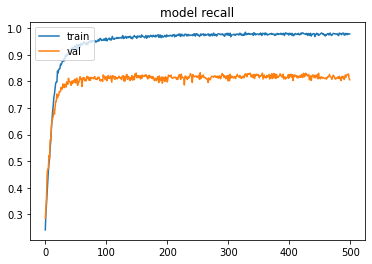

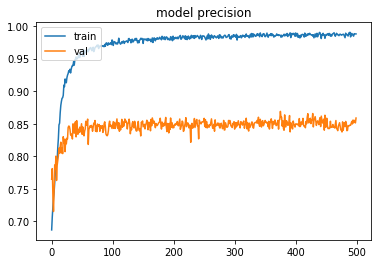

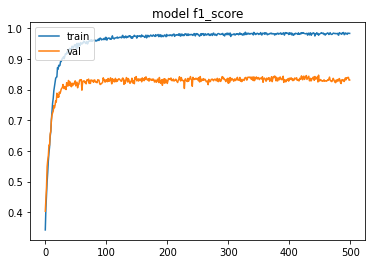

In [64]:


plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

              precision    recall  f1-score   support

          DC       0.85      0.91      0.88      1043
           F       0.84      0.82      0.83       308
           C       0.78      0.72      0.75       240
          LC       0.76      0.65      0.70       189
          TA       0.82      0.80      0.81       162
          PC       0.74      0.78      0.76       161
          PT       0.79      0.75      0.77       133
           A       0.86      0.77      0.81       137

    accuracy                           0.83      2373
   macro avg       0.81      0.78      0.79      2373
weighted avg       0.83      0.83      0.82      2373

[[953   5  19  32   5  21   3   5]
 [ 19 252   7   0   5   5  18   2]
 [ 42   3 174   5   4   7   1   4]
 [ 62   0   0 122   2   0   0   3]
 [  3  15   8   0 130   6   0   0]
 [ 20   3   7   0   2 126   2   1]
 [  7  17   1   1   2   3 100   2]
 [  9   4   6   0   8   2   3 105]]


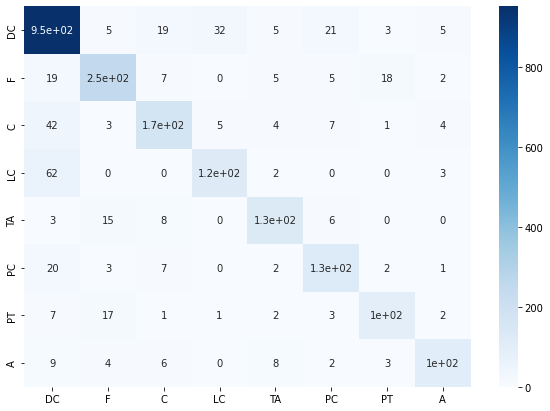

In [165]:
from sklearn.metrics import classification_report,confusion_matrix

# y_pred = model.predict(X_test_kbest)
# y_pred=np.argmax(y_pred, axis=1)

cr = classification_report(y_test, y_pred, target_names=['DC','F','C','LC','TA','PC','PT','A'])
print(cr)
     
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm = pd.DataFrame(cm)
cm.index=(['DC','F','C','LC','TA','PC','PT','A'])
cm.columns=(['DC','F','C','LC','TA','PC','PT','A'])

# import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues')
model.save('final_model_trial1.h5')

In [6]:
### trial 2
# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

onehot = tf.keras.utils.to_categorical(np.array(df.labels).reshape(-1,1), num_classes=len(set(df.labels)))
onehot.shape
y_train, y_test = onehot[:int(len(df)*i)], onehot[int(len(df)*i):]
y_train.shape, y_test.shape


model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))c
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(X_train_kbest, y_train, validation_data=(X_test_kbest, y_test), epochs = 500,batch_size=16, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)

y_pred = model.predict(X_test_kbest)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

cr = classification_report(y_test, y_pred, target_names=['DC','F','C','LC','TA','PC','PT','A'])
print(cr)
     
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm = pd.DataFrame(cm)
cm.index=(['DC','F','C','LC','TA','PC','PT','A'])
cm.columns=(['DC','F','C','LC','TA','PC','PT','A'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues')
model.save('final_model_trial2.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 10000)             0         
                                                                 
 gaussian_noise_1 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_7 (Dense)             (None, 1024)              10241024  
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               65664     
                                                      

Epoch 21/500
346/346 [==============================] - 7s 19ms/step - loss: 0.4447 - accuracy: 0.9685 - precision: 0.9098 - recall: 0.8304 - auc: 0.9858 - f1_score: 0.8670 - val_loss: 0.7941 - val_accuracy: 0.9480 - val_precision: 0.8266 - val_recall: 0.7391 - val_auc: 0.9577 - val_f1_score: 0.7799
Epoch 22/500
346/346 [==============================] - 7s 19ms/step - loss: 0.4432 - accuracy: 0.9674 - precision: 0.9024 - recall: 0.8284 - auc: 0.9864 - f1_score: 0.8625 - val_loss: 0.9150 - val_accuracy: 0.9431 - val_precision: 0.8005 - val_recall: 0.7252 - val_auc: 0.9504 - val_f1_score: 0.7612
Epoch 23/500
346/346 [==============================] - 7s 19ms/step - loss: 0.4034 - accuracy: 0.9697 - precision: 0.9081 - recall: 0.8425 - auc: 0.9883 - f1_score: 0.8731 - val_loss: 0.8128 - val_accuracy: 0.9519 - val_precision: 0.8366 - val_recall: 0.7640 - val_auc: 0.9591 - val_f1_score: 0.7982
Epoch 24/500
346/346 [==============================] - 7s 19ms/step - loss: 0.4231 - accuracy: 0

346/346 [==============================] - 7s 19ms/step - loss: 0.1882 - accuracy: 0.9888 - precision: 0.9656 - recall: 0.9440 - auc: 0.9962 - f1_score: 0.9544 - val_loss: 1.0423 - val_accuracy: 0.9563 - val_precision: 0.8437 - val_recall: 0.7981 - val_auc: 0.9530 - val_f1_score: 0.8206
Epoch 76/500
346/346 [==============================] - 7s 19ms/step - loss: 0.1371 - accuracy: 0.9917 - precision: 0.9741 - recall: 0.9588 - auc: 0.9981 - f1_score: 0.9662 - val_loss: 1.1540 - val_accuracy: 0.9552 - val_precision: 0.8352 - val_recall: 0.7990 - val_auc: 0.9485 - val_f1_score: 0.8169
Epoch 77/500
346/346 [==============================] - 7s 19ms/step - loss: 0.1807 - accuracy: 0.9885 - precision: 0.9642 - recall: 0.9431 - auc: 0.9967 - f1_score: 0.9532 - val_loss: 1.1590 - val_accuracy: 0.9553 - val_precision: 0.8322 - val_recall: 0.8045 - val_auc: 0.9466 - val_f1_score: 0.8186
Epoch 78/500
346/346 [==============================] - 7s 19ms/step - loss: 0.1660 - accuracy: 0.9897 - preci

346/346 [==============================] - 7s 19ms/step - loss: 0.1232 - accuracy: 0.9922 - precision: 0.9749 - recall: 0.9626 - auc: 0.9981 - f1_score: 0.9685 - val_loss: 1.3637 - val_accuracy: 0.9556 - val_precision: 0.8365 - val_recall: 0.8019 - val_auc: 0.9417 - val_f1_score: 0.8193
Epoch 130/500
346/346 [==============================] - 7s 19ms/step - loss: 0.1391 - accuracy: 0.9920 - precision: 0.9747 - recall: 0.9612 - auc: 0.9970 - f1_score: 0.9677 - val_loss: 1.1500 - val_accuracy: 0.9567 - val_precision: 0.8436 - val_recall: 0.8024 - val_auc: 0.9480 - val_f1_score: 0.8227
Epoch 131/500
346/346 [==============================] - 7s 19ms/step - loss: 0.1294 - accuracy: 0.9930 - precision: 0.9796 - recall: 0.9637 - auc: 0.9979 - f1_score: 0.9713 - val_loss: 1.1534 - val_accuracy: 0.9542 - val_precision: 0.8390 - val_recall: 0.7838 - val_auc: 0.9473 - val_f1_score: 0.8107
Epoch 132/500
346/346 [==============================] - 7s 19ms/step - loss: 0.1150 - accuracy: 0.9926 - pr

346/346 [==============================] - 6s 17ms/step - loss: 0.0998 - accuracy: 0.9944 - precision: 0.9821 - recall: 0.9727 - auc: 0.9983 - f1_score: 0.9773 - val_loss: 1.2226 - val_accuracy: 0.9572 - val_precision: 0.8483 - val_recall: 0.8011 - val_auc: 0.9451 - val_f1_score: 0.8242
Epoch 184/500
346/346 [==============================] - 5s 16ms/step - loss: 0.1014 - accuracy: 0.9938 - precision: 0.9810 - recall: 0.9689 - auc: 0.9986 - f1_score: 0.9747 - val_loss: 1.5286 - val_accuracy: 0.9549 - val_precision: 0.8378 - val_recall: 0.7922 - val_auc: 0.9417 - val_f1_score: 0.8145
Epoch 185/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0929 - accuracy: 0.9942 - precision: 0.9826 - recall: 0.9709 - auc: 0.9988 - f1_score: 0.9766 - val_loss: 1.4737 - val_accuracy: 0.9591 - val_precision: 0.8525 - val_recall: 0.8133 - val_auc: 0.9450 - val_f1_score: 0.8328
Epoch 186/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0871 - accuracy: 0.9945 - pr

346/346 [==============================] - 6s 16ms/step - loss: 0.0663 - accuracy: 0.9961 - precision: 0.9875 - recall: 0.9812 - auc: 0.9993 - f1_score: 0.9842 - val_loss: 2.0224 - val_accuracy: 0.9575 - val_precision: 0.8414 - val_recall: 0.8137 - val_auc: 0.9293 - val_f1_score: 0.8275
Epoch 238/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0862 - accuracy: 0.9954 - precision: 0.9844 - recall: 0.9785 - auc: 0.9986 - f1_score: 0.9813 - val_loss: 1.5866 - val_accuracy: 0.9578 - val_precision: 0.8483 - val_recall: 0.8062 - val_auc: 0.9403 - val_f1_score: 0.8270
Epoch 239/500
346/346 [==============================] - 6s 16ms/step - loss: 0.1110 - accuracy: 0.9939 - precision: 0.9821 - recall: 0.9691 - auc: 0.9981 - f1_score: 0.9754 - val_loss: 1.4145 - val_accuracy: 0.9591 - val_precision: 0.8544 - val_recall: 0.8108 - val_auc: 0.9411 - val_f1_score: 0.8320
Epoch 240/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0936 - accuracy: 0.9946 - pr

346/346 [==============================] - 6s 16ms/step - loss: 0.0902 - accuracy: 0.9953 - precision: 0.9847 - recall: 0.9774 - auc: 0.9987 - f1_score: 0.9809 - val_loss: 1.6369 - val_accuracy: 0.9566 - val_precision: 0.8378 - val_recall: 0.8095 - val_auc: 0.9370 - val_f1_score: 0.8239
Epoch 292/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0758 - accuracy: 0.9959 - precision: 0.9869 - recall: 0.9803 - auc: 0.9992 - f1_score: 0.9835 - val_loss: 1.6748 - val_accuracy: 0.9562 - val_precision: 0.8370 - val_recall: 0.8070 - val_auc: 0.9347 - val_f1_score: 0.8223
Epoch 293/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0969 - accuracy: 0.9946 - precision: 0.9830 - recall: 0.9740 - auc: 0.9984 - f1_score: 0.9784 - val_loss: 1.4810 - val_accuracy: 0.9568 - val_precision: 0.8398 - val_recall: 0.8083 - val_auc: 0.9399 - val_f1_score: 0.8243
Epoch 294/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0876 - accuracy: 0.9949 - pr

346/346 [==============================] - 6s 16ms/step - loss: 0.0788 - accuracy: 0.9956 - precision: 0.9853 - recall: 0.9794 - auc: 0.9988 - f1_score: 0.9822 - val_loss: 1.6270 - val_accuracy: 0.9573 - val_precision: 0.8417 - val_recall: 0.8112 - val_auc: 0.9358 - val_f1_score: 0.8268
Epoch 346/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0842 - accuracy: 0.9950 - precision: 0.9845 - recall: 0.9754 - auc: 0.9990 - f1_score: 0.9798 - val_loss: 2.0174 - val_accuracy: 0.9578 - val_precision: 0.8420 - val_recall: 0.8150 - val_auc: 0.9335 - val_f1_score: 0.8287
Epoch 347/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0949 - accuracy: 0.9949 - precision: 0.9831 - recall: 0.9762 - auc: 0.9984 - f1_score: 0.9795 - val_loss: 1.7689 - val_accuracy: 0.9573 - val_precision: 0.8428 - val_recall: 0.8091 - val_auc: 0.9344 - val_f1_score: 0.8261
Epoch 348/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0777 - accuracy: 0.9951 - pr

346/346 [==============================] - 6s 16ms/step - loss: 0.0697 - accuracy: 0.9962 - precision: 0.9896 - recall: 0.9796 - auc: 0.9994 - f1_score: 0.9844 - val_loss: 1.4047 - val_accuracy: 0.9571 - val_precision: 0.8435 - val_recall: 0.8062 - val_auc: 0.9426 - val_f1_score: 0.8244
Epoch 400/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0704 - accuracy: 0.9953 - precision: 0.9847 - recall: 0.9780 - auc: 0.9992 - f1_score: 0.9812 - val_loss: 2.0660 - val_accuracy: 0.9588 - val_precision: 0.8484 - val_recall: 0.8158 - val_auc: 0.9374 - val_f1_score: 0.8323
Epoch 401/500
346/346 [==============================] - 5s 16ms/step - loss: 0.0667 - accuracy: 0.9960 - precision: 0.9875 - recall: 0.9809 - auc: 0.9993 - f1_score: 0.9840 - val_loss: 1.6445 - val_accuracy: 0.9594 - val_precision: 0.8541 - val_recall: 0.8142 - val_auc: 0.9366 - val_f1_score: 0.8338
Epoch 402/500
346/346 [==============================] - 5s 16ms/step - loss: 0.0580 - accuracy: 0.9959 - pr

346/346 [==============================] - 6s 16ms/step - loss: 0.0795 - accuracy: 0.9955 - precision: 0.9849 - recall: 0.9789 - auc: 0.9989 - f1_score: 0.9818 - val_loss: 1.6007 - val_accuracy: 0.9575 - val_precision: 0.8458 - val_recall: 0.8070 - val_auc: 0.9369 - val_f1_score: 0.8262
Epoch 454/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0903 - accuracy: 0.9949 - precision: 0.9841 - recall: 0.9751 - auc: 0.9987 - f1_score: 0.9794 - val_loss: 1.6781 - val_accuracy: 0.9558 - val_precision: 0.8433 - val_recall: 0.7935 - val_auc: 0.9322 - val_f1_score: 0.8177
Epoch 455/500
346/346 [==============================] - 5s 16ms/step - loss: 0.0793 - accuracy: 0.9956 - precision: 0.9867 - recall: 0.9781 - auc: 0.9991 - f1_score: 0.9823 - val_loss: 1.7560 - val_accuracy: 0.9578 - val_precision: 0.8460 - val_recall: 0.8099 - val_auc: 0.9344 - val_f1_score: 0.8280
Epoch 456/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0813 - accuracy: 0.9953 - pr

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

              precision    recall  f1-score   support

          DC       0.82      0.91      0.86       996
           F       0.83      0.82      0.83       323
           C       0.83      0.73      0.78       233
          LC       0.64      0.67      0.66       220
          TA       0.90      0.82      0.86       163
          PC       0.91      0.67      0.77       161
          PT       0.85      0.75      0.80       135
           A       0.93      0.81      0.86       142

    accuracy                           0.82      2373
   macro avg       0.84      0.77      0.80      2373
weighted avg       0.82      0.82      0.82      2373

[[908   5  10  67   1   4   1   0]
 [ 36 265   6   1   2   4   9   0]
 [ 37  12 169   9   4   0   0   2]
 [ 63   0   5 147   1   0   1   3]
 [  8  15   4   0 133   1   1   1]
 [ 40   3   4   0   2 108   4   0]
 [ 13  15   0   1   2   0 101   3]
 [  9   4   5   3   2   2   2 115]]


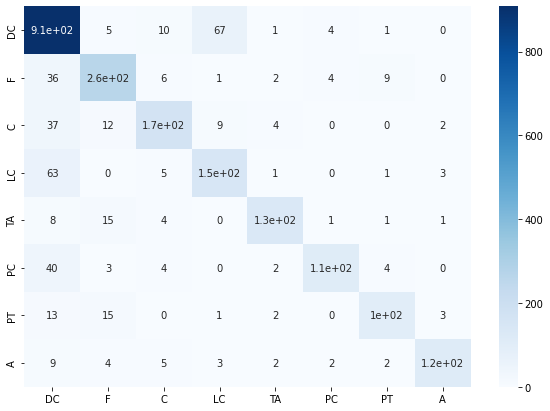

In [11]:
y_pred = model.predict(X_test_kbest)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

cr = classification_report(y_test, y_pred, target_names=['DC','F','C','LC','TA','PC','PT','A'])
print(cr)
     
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm = pd.DataFrame(cm)
cm.index=(['DC','F','C','LC','TA','PC','PT','A'])
cm.columns=(['DC','F','C','LC','TA','PC','PT','A'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues')
model.save('final_model_trial2.h5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_9 (Dropout)         (None, 10000)             0         
                                                                 
 gaussian_noise_3 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_21 (Dense)            (None, 1024)              10241024  
                                                                 
 dense_22 (Dense)            (None, 512)               524800    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 128)               65664     
                                                      

Epoch 21/500
346/346 [==============================] - 6s 17ms/step - loss: 0.4624 - accuracy: 0.9666 - precision: 0.9043 - recall: 0.8195 - auc: 0.9845 - f1_score: 0.8582 - val_loss: 0.8287 - val_accuracy: 0.9475 - val_precision: 0.8179 - val_recall: 0.7459 - val_auc: 0.9573 - val_f1_score: 0.7788
Epoch 22/500
346/346 [==============================] - 6s 16ms/step - loss: 0.4398 - accuracy: 0.9690 - precision: 0.9082 - recall: 0.8367 - auc: 0.9863 - f1_score: 0.8701 - val_loss: 0.8469 - val_accuracy: 0.9507 - val_precision: 0.8329 - val_recall: 0.7581 - val_auc: 0.9549 - val_f1_score: 0.7908
Epoch 23/500
346/346 [==============================] - 6s 16ms/step - loss: 0.4383 - accuracy: 0.9689 - precision: 0.9088 - recall: 0.8347 - auc: 0.9858 - f1_score: 0.8688 - val_loss: 0.8068 - val_accuracy: 0.9483 - val_precision: 0.8343 - val_recall: 0.7320 - val_auc: 0.9547 - val_f1_score: 0.7778
Epoch 24/500
346/346 [==============================] - 6s 16ms/step - loss: 0.3963 - accuracy: 0

346/346 [==============================] - 6s 16ms/step - loss: 0.1507 - accuracy: 0.9909 - precision: 0.9707 - recall: 0.9561 - auc: 0.9975 - f1_score: 0.9631 - val_loss: 1.2901 - val_accuracy: 0.9576 - val_precision: 0.8406 - val_recall: 0.8158 - val_auc: 0.9454 - val_f1_score: 0.8264
Epoch 76/500
346/346 [==============================] - 6s 16ms/step - loss: 0.1828 - accuracy: 0.9886 - precision: 0.9647 - recall: 0.9429 - auc: 0.9964 - f1_score: 0.9535 - val_loss: 1.1852 - val_accuracy: 0.9544 - val_precision: 0.8342 - val_recall: 0.7931 - val_auc: 0.9420 - val_f1_score: 0.8126
Epoch 77/500
346/346 [==============================] - 6s 16ms/step - loss: 0.1840 - accuracy: 0.9883 - precision: 0.9662 - recall: 0.9389 - auc: 0.9966 - f1_score: 0.9518 - val_loss: 1.1089 - val_accuracy: 0.9594 - val_precision: 0.8529 - val_recall: 0.8158 - val_auc: 0.9498 - val_f1_score: 0.8322
Epoch 78/500
346/346 [==============================] - 6s 17ms/step - loss: 0.1532 - accuracy: 0.9898 - preci

346/346 [==============================] - 7s 20ms/step - loss: 0.1270 - accuracy: 0.9924 - precision: 0.9751 - recall: 0.9637 - auc: 0.9977 - f1_score: 0.9692 - val_loss: 1.0713 - val_accuracy: 0.9586 - val_precision: 0.8473 - val_recall: 0.8163 - val_auc: 0.9504 - val_f1_score: 0.8294
Epoch 130/500
346/346 [==============================] - 7s 19ms/step - loss: 0.1341 - accuracy: 0.9921 - precision: 0.9752 - recall: 0.9608 - auc: 0.9979 - f1_score: 0.9678 - val_loss: 1.0332 - val_accuracy: 0.9610 - val_precision: 0.8602 - val_recall: 0.8217 - val_auc: 0.9525 - val_f1_score: 0.8391
Epoch 131/500
346/346 [==============================] - 7s 19ms/step - loss: 0.0984 - accuracy: 0.9932 - precision: 0.9777 - recall: 0.9678 - auc: 0.9990 - f1_score: 0.9726 - val_loss: 1.3091 - val_accuracy: 0.9567 - val_precision: 0.8350 - val_recall: 0.8146 - val_auc: 0.9404 - val_f1_score: 0.8223
Epoch 132/500
346/346 [==============================] - 7s 20ms/step - loss: 0.1366 - accuracy: 0.9914 - pr

346/346 [==============================] - 7s 19ms/step - loss: 0.1146 - accuracy: 0.9933 - precision: 0.9799 - recall: 0.9666 - auc: 0.9983 - f1_score: 0.9729 - val_loss: 1.6411 - val_accuracy: 0.9563 - val_precision: 0.8392 - val_recall: 0.8049 - val_auc: 0.9359 - val_f1_score: 0.8205
Epoch 184/500
346/346 [==============================] - 7s 19ms/step - loss: 0.1121 - accuracy: 0.9926 - precision: 0.9768 - recall: 0.9639 - auc: 0.9985 - f1_score: 0.9701 - val_loss: 1.2928 - val_accuracy: 0.9593 - val_precision: 0.8512 - val_recall: 0.8171 - val_auc: 0.9455 - val_f1_score: 0.8321
Epoch 185/500
346/346 [==============================] - 7s 19ms/step - loss: 0.0988 - accuracy: 0.9937 - precision: 0.9799 - recall: 0.9691 - auc: 0.9989 - f1_score: 0.9743 - val_loss: 1.1321 - val_accuracy: 0.9574 - val_precision: 0.8440 - val_recall: 0.8091 - val_auc: 0.9475 - val_f1_score: 0.8241
Epoch 186/500
346/346 [==============================] - 7s 19ms/step - loss: 0.1270 - accuracy: 0.9927 - pr

346/346 [==============================] - 7s 19ms/step - loss: 0.1090 - accuracy: 0.9936 - precision: 0.9818 - recall: 0.9668 - auc: 0.9985 - f1_score: 0.9740 - val_loss: 1.7198 - val_accuracy: 0.9579 - val_precision: 0.8455 - val_recall: 0.8116 - val_auc: 0.9364 - val_f1_score: 0.8274
Epoch 238/500
346/346 [==============================] - 7s 19ms/step - loss: 0.0988 - accuracy: 0.9933 - precision: 0.9790 - recall: 0.9673 - auc: 0.9986 - f1_score: 0.9729 - val_loss: 1.4324 - val_accuracy: 0.9602 - val_precision: 0.8545 - val_recall: 0.8217 - val_auc: 0.9409 - val_f1_score: 0.8365
Epoch 239/500
346/346 [==============================] - 7s 19ms/step - loss: 0.0917 - accuracy: 0.9942 - precision: 0.9814 - recall: 0.9720 - auc: 0.9987 - f1_score: 0.9765 - val_loss: 1.4756 - val_accuracy: 0.9594 - val_precision: 0.8511 - val_recall: 0.8188 - val_auc: 0.9394 - val_f1_score: 0.8340
Epoch 240/500
346/346 [==============================] - 7s 19ms/step - loss: 0.0893 - accuracy: 0.9939 - pr

346/346 [==============================] - 7s 19ms/step - loss: 0.0922 - accuracy: 0.9944 - precision: 0.9813 - recall: 0.9742 - auc: 0.9983 - f1_score: 0.9776 - val_loss: 1.3889 - val_accuracy: 0.9601 - val_precision: 0.8492 - val_recall: 0.8281 - val_auc: 0.9397 - val_f1_score: 0.8375
Epoch 292/500
346/346 [==============================] - 7s 19ms/step - loss: 0.1137 - accuracy: 0.9937 - precision: 0.9792 - recall: 0.9698 - auc: 0.9978 - f1_score: 0.9743 - val_loss: 1.1403 - val_accuracy: 0.9606 - val_precision: 0.8584 - val_recall: 0.8201 - val_auc: 0.9484 - val_f1_score: 0.8373
Epoch 293/500
346/346 [==============================] - 7s 19ms/step - loss: 0.0754 - accuracy: 0.9955 - precision: 0.9851 - recall: 0.9789 - auc: 0.9992 - f1_score: 0.9819 - val_loss: 1.3667 - val_accuracy: 0.9604 - val_precision: 0.8529 - val_recall: 0.8260 - val_auc: 0.9394 - val_f1_score: 0.8374
Epoch 294/500
346/346 [==============================] - 7s 19ms/step - loss: 0.0950 - accuracy: 0.9941 - pr

346/346 [==============================] - 7s 19ms/step - loss: 0.0700 - accuracy: 0.9953 - precision: 0.9856 - recall: 0.9767 - auc: 0.9996 - f1_score: 0.9810 - val_loss: 1.3442 - val_accuracy: 0.9610 - val_precision: 0.8583 - val_recall: 0.8243 - val_auc: 0.9455 - val_f1_score: 0.8396
Epoch 346/500
346/346 [==============================] - 7s 20ms/step - loss: 0.0934 - accuracy: 0.9946 - precision: 0.9822 - recall: 0.9747 - auc: 0.9986 - f1_score: 0.9783 - val_loss: 1.2403 - val_accuracy: 0.9620 - val_precision: 0.8619 - val_recall: 0.8285 - val_auc: 0.9469 - val_f1_score: 0.8442
Epoch 347/500
346/346 [==============================] - 7s 19ms/step - loss: 0.0696 - accuracy: 0.9950 - precision: 0.9829 - recall: 0.9771 - auc: 0.9993 - f1_score: 0.9799 - val_loss: 1.4244 - val_accuracy: 0.9608 - val_precision: 0.8521 - val_recall: 0.8306 - val_auc: 0.9415 - val_f1_score: 0.8406
Epoch 348/500
346/346 [==============================] - 7s 19ms/step - loss: 0.0995 - accuracy: 0.9935 - pr

346/346 [==============================] - 7s 19ms/step - loss: 0.0840 - accuracy: 0.9950 - precision: 0.9849 - recall: 0.9747 - auc: 0.9991 - f1_score: 0.9796 - val_loss: 1.3293 - val_accuracy: 0.9603 - val_precision: 0.8568 - val_recall: 0.8192 - val_auc: 0.9432 - val_f1_score: 0.8362
Epoch 400/500
346/346 [==============================] - 7s 20ms/step - loss: 0.0673 - accuracy: 0.9954 - precision: 0.9860 - recall: 0.9769 - auc: 0.9996 - f1_score: 0.9812 - val_loss: 1.7366 - val_accuracy: 0.9581 - val_precision: 0.8457 - val_recall: 0.8129 - val_auc: 0.9360 - val_f1_score: 0.8279
Epoch 401/500
346/346 [==============================] - 7s 19ms/step - loss: 0.0844 - accuracy: 0.9946 - precision: 0.9834 - recall: 0.9736 - auc: 0.9989 - f1_score: 0.9783 - val_loss: 1.4947 - val_accuracy: 0.9590 - val_precision: 0.8486 - val_recall: 0.8175 - val_auc: 0.9403 - val_f1_score: 0.8313
Epoch 402/500
346/346 [==============================] - 7s 20ms/step - loss: 0.0806 - accuracy: 0.9949 - pr

346/346 [==============================] - 7s 20ms/step - loss: 0.0582 - accuracy: 0.9955 - precision: 0.9867 - recall: 0.9769 - auc: 0.9997 - f1_score: 0.9816 - val_loss: 1.7456 - val_accuracy: 0.9621 - val_precision: 0.8599 - val_recall: 0.8327 - val_auc: 0.9382 - val_f1_score: 0.8447
Epoch 454/500
346/346 [==============================] - 7s 19ms/step - loss: 0.1018 - accuracy: 0.9938 - precision: 0.9812 - recall: 0.9693 - auc: 0.9985 - f1_score: 0.9750 - val_loss: 1.4278 - val_accuracy: 0.9623 - val_precision: 0.8655 - val_recall: 0.8272 - val_auc: 0.9451 - val_f1_score: 0.8449
Epoch 455/500
346/346 [==============================] - 7s 19ms/step - loss: 0.0813 - accuracy: 0.9951 - precision: 0.9845 - recall: 0.9763 - auc: 0.9990 - f1_score: 0.9803 - val_loss: 1.4031 - val_accuracy: 0.9615 - val_precision: 0.8595 - val_recall: 0.8276 - val_auc: 0.9438 - val_f1_score: 0.8416
Epoch 456/500
346/346 [==============================] - 7s 19ms/step - loss: 0.0798 - accuracy: 0.9948 - pr

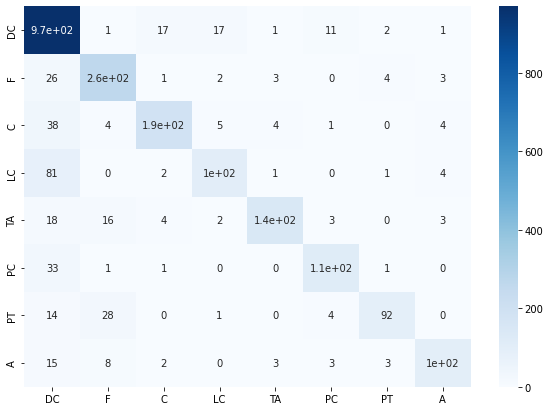

In [15]:
### trial 3
# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

onehot = tf.keras.utils.to_categorical(np.array(df.labels).reshape(-1,1), num_classes=len(set(df.labels)))
onehot.shape
y_train, y_test = onehot[:int(len(df)*i)], onehot[int(len(df)*i):]
y_train.shape, y_test.shape


model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(X_train_kbest, y_train, validation_data=(X_test_kbest, y_test), epochs = 500,batch_size=16, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)

y_pred = model.predict(X_test_kbest)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

cr = classification_report(y_test, y_pred, target_names=['DC','F','C','LC','TA','PC','PT','A'])
print(cr)
     
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm = pd.DataFrame(cm)
cm.index=(['DC','F','C','LC','TA','PC','PT','A'])
cm.columns=(['DC','F','C','LC','TA','PC','PT','A'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues')
model.save('final_model_trial3.h5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 10000)             0         
                                                                 
 gaussian_noise_4 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_28 (Dense)            (None, 1024)              10241024  
                                                                 
 dense_29 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               65664     
                                                      

346/346 [==============================] - 7s 21ms/step - loss: 0.2456 - accuracy: 0.9841 - precision: 0.9523 - recall: 0.9189 - auc: 0.9944 - f1_score: 0.9348 - val_loss: 0.8451 - val_accuracy: 0.9531 - val_precision: 0.8296 - val_recall: 0.7859 - val_auc: 0.9616 - val_f1_score: 0.8070
Epoch 48/500
346/346 [==============================] - 7s 21ms/step - loss: 0.2101 - accuracy: 0.9867 - precision: 0.9604 - recall: 0.9323 - auc: 0.9958 - f1_score: 0.9456 - val_loss: 1.0922 - val_accuracy: 0.9523 - val_precision: 0.8221 - val_recall: 0.7889 - val_auc: 0.9520 - val_f1_score: 0.8052
Epoch 49/500
346/346 [==============================] - 7s 20ms/step - loss: 0.2254 - accuracy: 0.9855 - precision: 0.9567 - recall: 0.9258 - auc: 0.9953 - f1_score: 0.9404 - val_loss: 0.8105 - val_accuracy: 0.9568 - val_precision: 0.8515 - val_recall: 0.7927 - val_auc: 0.9610 - val_f1_score: 0.8201
Epoch 50/500
346/346 [==============================] - 7s 21ms/step - loss: 0.2375 - accuracy: 0.9849 - preci

346/346 [==============================] - 7s 22ms/step - loss: 0.1271 - accuracy: 0.9929 - precision: 0.9782 - recall: 0.9644 - auc: 0.9978 - f1_score: 0.9711 - val_loss: 0.9436 - val_accuracy: 0.9575 - val_precision: 0.8483 - val_recall: 0.8036 - val_auc: 0.9549 - val_f1_score: 0.8239
Epoch 104/500
346/346 [==============================] - 8s 22ms/step - loss: 0.1161 - accuracy: 0.9935 - precision: 0.9804 - recall: 0.9675 - auc: 0.9986 - f1_score: 0.9737 - val_loss: 1.2952 - val_accuracy: 0.9583 - val_precision: 0.8457 - val_recall: 0.8154 - val_auc: 0.9478 - val_f1_score: 0.8300
Epoch 105/500
346/346 [==============================] - 6s 16ms/step - loss: 0.1392 - accuracy: 0.9917 - precision: 0.9733 - recall: 0.9599 - auc: 0.9979 - f1_score: 0.9664 - val_loss: 1.0490 - val_accuracy: 0.9569 - val_precision: 0.8482 - val_recall: 0.7981 - val_auc: 0.9538 - val_f1_score: 0.8220
Epoch 106/500
346/346 [==============================] - 6s 16ms/step - loss: 0.1601 - accuracy: 0.9915 - pr

346/346 [==============================] - 6s 16ms/step - loss: 0.1044 - accuracy: 0.9936 - precision: 0.9795 - recall: 0.9689 - auc: 0.9984 - f1_score: 0.9740 - val_loss: 1.1594 - val_accuracy: 0.9570 - val_precision: 0.8439 - val_recall: 0.8045 - val_auc: 0.9489 - val_f1_score: 0.8219
Epoch 158/500
346/346 [==============================] - 6s 18ms/step - loss: 0.1208 - accuracy: 0.9932 - precision: 0.9783 - recall: 0.9669 - auc: 0.9974 - f1_score: 0.9724 - val_loss: 1.0913 - val_accuracy: 0.9549 - val_precision: 0.8364 - val_recall: 0.7948 - val_auc: 0.9441 - val_f1_score: 0.8143
Epoch 159/500
346/346 [==============================] - 7s 19ms/step - loss: 0.1040 - accuracy: 0.9942 - precision: 0.9810 - recall: 0.9722 - auc: 0.9984 - f1_score: 0.9765 - val_loss: 1.1449 - val_accuracy: 0.9579 - val_precision: 0.8437 - val_recall: 0.8142 - val_auc: 0.9477 - val_f1_score: 0.8270
Epoch 160/500
346/346 [==============================] - 6s 16ms/step - loss: 0.1135 - accuracy: 0.9936 - pr

346/346 [==============================] - 6s 16ms/step - loss: 0.1082 - accuracy: 0.9940 - precision: 0.9812 - recall: 0.9706 - auc: 0.9982 - f1_score: 0.9756 - val_loss: 1.4808 - val_accuracy: 0.9555 - val_precision: 0.8343 - val_recall: 0.8040 - val_auc: 0.9349 - val_f1_score: 0.8183
Epoch 212/500
346/346 [==============================] - 5s 16ms/step - loss: 0.0891 - accuracy: 0.9951 - precision: 0.9850 - recall: 0.9754 - auc: 0.9985 - f1_score: 0.9801 - val_loss: 1.4682 - val_accuracy: 0.9562 - val_precision: 0.8408 - val_recall: 0.8015 - val_auc: 0.9387 - val_f1_score: 0.8199
Epoch 213/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0861 - accuracy: 0.9952 - precision: 0.9840 - recall: 0.9774 - auc: 0.9989 - f1_score: 0.9806 - val_loss: 1.3860 - val_accuracy: 0.9566 - val_precision: 0.8354 - val_recall: 0.8129 - val_auc: 0.9418 - val_f1_score: 0.8237
Epoch 214/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0862 - accuracy: 0.9952 - pr

346/346 [==============================] - 5s 16ms/step - loss: 0.0868 - accuracy: 0.9952 - precision: 0.9847 - recall: 0.9771 - auc: 0.9987 - f1_score: 0.9807 - val_loss: 1.4295 - val_accuracy: 0.9579 - val_precision: 0.8464 - val_recall: 0.8104 - val_auc: 0.9399 - val_f1_score: 0.8276
Epoch 266/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0876 - accuracy: 0.9954 - precision: 0.9860 - recall: 0.9774 - auc: 0.9987 - f1_score: 0.9815 - val_loss: 1.4051 - val_accuracy: 0.9584 - val_precision: 0.8486 - val_recall: 0.8125 - val_auc: 0.9402 - val_f1_score: 0.8296
Epoch 267/500
346/346 [==============================] - 5s 16ms/step - loss: 0.0899 - accuracy: 0.9947 - precision: 0.9838 - recall: 0.9734 - auc: 0.9988 - f1_score: 0.9784 - val_loss: 1.2524 - val_accuracy: 0.9592 - val_precision: 0.8517 - val_recall: 0.8154 - val_auc: 0.9407 - val_f1_score: 0.8328
Epoch 268/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0876 - accuracy: 0.9951 - pr

346/346 [==============================] - 6s 17ms/step - loss: 0.0836 - accuracy: 0.9953 - precision: 0.9854 - recall: 0.9772 - auc: 0.9989 - f1_score: 0.9812 - val_loss: 1.3911 - val_accuracy: 0.9567 - val_precision: 0.8406 - val_recall: 0.8066 - val_auc: 0.9370 - val_f1_score: 0.8232
Epoch 320/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0697 - accuracy: 0.9962 - precision: 0.9894 - recall: 0.9803 - auc: 0.9992 - f1_score: 0.9847 - val_loss: 1.5948 - val_accuracy: 0.9573 - val_precision: 0.8390 - val_recall: 0.8150 - val_auc: 0.9355 - val_f1_score: 0.8262
Epoch 321/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0811 - accuracy: 0.9955 - precision: 0.9858 - recall: 0.9783 - auc: 0.9986 - f1_score: 0.9819 - val_loss: 1.4665 - val_accuracy: 0.9579 - val_precision: 0.8467 - val_recall: 0.8099 - val_auc: 0.9373 - val_f1_score: 0.8273
Epoch 322/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0644 - accuracy: 0.9965 - pr

346/346 [==============================] - 6s 17ms/step - loss: 0.0804 - accuracy: 0.9953 - precision: 0.9851 - recall: 0.9774 - auc: 0.9989 - f1_score: 0.9811 - val_loss: 1.2854 - val_accuracy: 0.9604 - val_precision: 0.8598 - val_recall: 0.8167 - val_auc: 0.9431 - val_f1_score: 0.8376
Epoch 374/500
346/346 [==============================] - 6s 17ms/step - loss: 0.0866 - accuracy: 0.9956 - precision: 0.9881 - recall: 0.9763 - auc: 0.9988 - f1_score: 0.9820 - val_loss: 1.3502 - val_accuracy: 0.9589 - val_precision: 0.8535 - val_recall: 0.8104 - val_auc: 0.9400 - val_f1_score: 0.8313
Epoch 375/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0891 - accuracy: 0.9955 - precision: 0.9867 - recall: 0.9769 - auc: 0.9987 - f1_score: 0.9816 - val_loss: 1.2509 - val_accuracy: 0.9585 - val_precision: 0.8556 - val_recall: 0.8040 - val_auc: 0.9437 - val_f1_score: 0.8281
Epoch 376/500
346/346 [==============================] - 6s 16ms/step - loss: 0.0599 - accuracy: 0.9967 - pr

346/346 [==============================] - 7s 20ms/step - loss: 0.0904 - accuracy: 0.9956 - precision: 0.9862 - recall: 0.9787 - auc: 0.9986 - f1_score: 0.9823 - val_loss: 1.0764 - val_accuracy: 0.9582 - val_precision: 0.8571 - val_recall: 0.7990 - val_auc: 0.9489 - val_f1_score: 0.8259
Epoch 428/500
346/346 [==============================] - 7s 20ms/step - loss: 0.0942 - accuracy: 0.9950 - precision: 0.9843 - recall: 0.9754 - auc: 0.9987 - f1_score: 0.9797 - val_loss: 1.3588 - val_accuracy: 0.9598 - val_precision: 0.8629 - val_recall: 0.8066 - val_auc: 0.9438 - val_f1_score: 0.8326
Epoch 429/500
346/346 [==============================] - 12s 35ms/step - loss: 0.0950 - accuracy: 0.9952 - precision: 0.9849 - recall: 0.9769 - auc: 0.9989 - f1_score: 0.9807 - val_loss: 1.4692 - val_accuracy: 0.9597 - val_precision: 0.8576 - val_recall: 0.8121 - val_auc: 0.9422 - val_f1_score: 0.8342
Epoch 430/500
346/346 [==============================] - 11s 30ms/step - loss: 0.0578 - accuracy: 0.9969 - 

346/346 [==============================] - 7s 20ms/step - loss: 0.0770 - accuracy: 0.9957 - precision: 0.9860 - recall: 0.9796 - auc: 0.9992 - f1_score: 0.9827 - val_loss: 1.5607 - val_accuracy: 0.9581 - val_precision: 0.8448 - val_recall: 0.8146 - val_auc: 0.9386 - val_f1_score: 0.8296
Epoch 482/500
346/346 [==============================] - 7s 20ms/step - loss: 0.0840 - accuracy: 0.9949 - precision: 0.9854 - recall: 0.9738 - auc: 0.9991 - f1_score: 0.9794 - val_loss: 1.4627 - val_accuracy: 0.9596 - val_precision: 0.8519 - val_recall: 0.8192 - val_auc: 0.9406 - val_f1_score: 0.8356
Epoch 483/500
346/346 [==============================] - 7s 20ms/step - loss: 0.0758 - accuracy: 0.9954 - precision: 0.9853 - recall: 0.9781 - auc: 0.9992 - f1_score: 0.9816 - val_loss: 1.3187 - val_accuracy: 0.9595 - val_precision: 0.8524 - val_recall: 0.8180 - val_auc: 0.9459 - val_f1_score: 0.8344
Epoch 484/500
346/346 [==============================] - 7s 20ms/step - loss: 0.0637 - accuracy: 0.9961 - pr

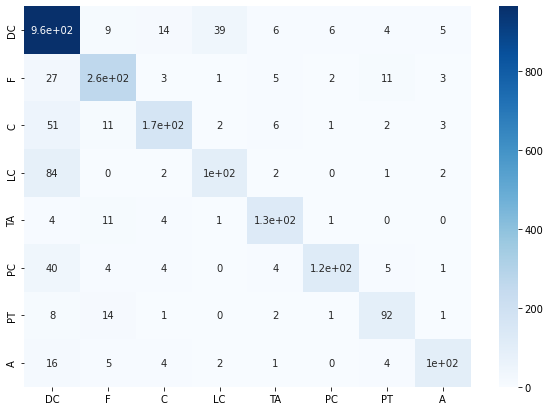

In [17]:
### trial 4
# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

onehot = tf.keras.utils.to_categorical(np.array(df.labels).reshape(-1,1), num_classes=len(set(df.labels)))
onehot.shape
y_train, y_test = onehot[:int(len(df)*i)], onehot[int(len(df)*i):]
y_train.shape, y_test.shape


model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(X_train_kbest, y_train, validation_data=(X_test_kbest, y_test), epochs = 500,batch_size=16, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)

y_pred = model.predict(X_test_kbest)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

cr = classification_report(y_test, y_pred, target_names=['DC','F','C','LC','TA','PC','PT','A'])
print(cr)
     
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm = pd.DataFrame(cm)
cm.index=(['DC','F','C','LC','TA','PC','PT','A'])
cm.columns=(['DC','F','C','LC','TA','PC','PT','A'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues')
model.save('final_model_trial4.h5')

In [ ]:
### trial 5
# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

onehot = tf.keras.utils.to_categorical(np.array(df.labels).reshape(-1,1), num_classes=len(set(df.labels)))
onehot.shape
y_train, y_test = onehot[:int(len(df)*i)], onehot[int(len(df)*i):]
y_train.shape, y_test.shape


model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(X_train_kbest, y_train, validation_data=(X_test_kbest, y_test), epochs = 500,batch_size=16, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)

y_pred = model.predict(X_test_kbest)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

cr = classification_report(y_test, y_pred, target_names=['DC','F','C','LC','TA','PC','PT','A'])
print(cr)
     
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm = pd.DataFrame(cm)
cm.index=(['DC','F','C','LC','TA','PC','PT','A'])
cm.columns=(['DC','F','C','LC','TA','PC','PT','A'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues')
model.save('final_model_trial5.h5')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_15 (Dropout)        (None, 10000)             0         
                                                                 
 gaussian_noise_5 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_35 (Dense)            (None, 1024)              10241024  
                                                                 
 dense_36 (Dense)            (None, 512)               524800    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               65664     
                                                      

Epoch 21/500
346/346 [==============================] - 7s 20ms/step - loss: 0.5114 - accuracy: 0.9614 - precision: 0.8915 - recall: 0.7868 - auc: 0.9827 - f1_score: 0.8341 - val_loss: 0.9068 - val_accuracy: 0.9429 - val_precision: 0.8053 - val_recall: 0.7164 - val_auc: 0.9497 - val_f1_score: 0.7574
Epoch 22/500
346/346 [==============================] - 7s 20ms/step - loss: 0.4686 - accuracy: 0.9664 - precision: 0.9038 - recall: 0.8181 - auc: 0.9847 - f1_score: 0.8578 - val_loss: 0.8751 - val_accuracy: 0.9480 - val_precision: 0.8155 - val_recall: 0.7543 - val_auc: 0.9550 - val_f1_score: 0.7832
Epoch 23/500
346/346 [==============================] - 7s 20ms/step - loss: 0.4717 - accuracy: 0.9657 - precision: 0.8994 - recall: 0.8170 - auc: 0.9848 - f1_score: 0.8551 - val_loss: 0.7640 - val_accuracy: 0.9477 - val_precision: 0.8287 - val_recall: 0.7337 - val_auc: 0.9608 - val_f1_score: 0.7765
Epoch 24/500
346/346 [==============================] - 7s 20ms/step - loss: 0.4643 - accuracy: 0

346/346 [==============================] - 7s 20ms/step - loss: 0.1485 - accuracy: 0.9906 - precision: 0.9716 - recall: 0.9525 - auc: 0.9974 - f1_score: 0.9617 - val_loss: 0.9769 - val_accuracy: 0.9617 - val_precision: 0.8625 - val_recall: 0.8247 - val_auc: 0.9525 - val_f1_score: 0.8426
Epoch 76/500
346/346 [==============================] - 7s 20ms/step - loss: 0.1814 - accuracy: 0.9883 - precision: 0.9634 - recall: 0.9420 - auc: 0.9962 - f1_score: 0.9522 - val_loss: 1.0709 - val_accuracy: 0.9580 - val_precision: 0.8465 - val_recall: 0.8108 - val_auc: 0.9522 - val_f1_score: 0.8283
Epoch 77/500
346/346 [==============================] - 7s 20ms/step - loss: 0.1607 - accuracy: 0.9892 - precision: 0.9669 - recall: 0.9458 - auc: 0.9976 - f1_score: 0.9560 - val_loss: 1.2018 - val_accuracy: 0.9592 - val_precision: 0.8524 - val_recall: 0.8150 - val_auc: 0.9479 - val_f1_score: 0.8325
Epoch 78/500
346/346 [==============================] - 7s 20ms/step - loss: 0.1675 - accuracy: 0.9899 - preci

346/346 [==============================] - 7s 20ms/step - loss: 0.1228 - accuracy: 0.9927 - precision: 0.9776 - recall: 0.9635 - auc: 0.9983 - f1_score: 0.9703 - val_loss: 0.9948 - val_accuracy: 0.9610 - val_precision: 0.8567 - val_recall: 0.8264 - val_auc: 0.9564 - val_f1_score: 0.8405
Epoch 130/500
346/346 [==============================] - 7s 20ms/step - loss: 0.1321 - accuracy: 0.9918 - precision: 0.9752 - recall: 0.9585 - auc: 0.9977 - f1_score: 0.9665 - val_loss: 1.1831 - val_accuracy: 0.9571 - val_precision: 0.8441 - val_recall: 0.8053 - val_auc: 0.9457 - val_f1_score: 0.8225
Epoch 131/500
346/346 [==============================] - 7s 20ms/step - loss: 0.1219 - accuracy: 0.9927 - precision: 0.9762 - recall: 0.9650 - auc: 0.9977 - f1_score: 0.9705 - val_loss: 1.3398 - val_accuracy: 0.9589 - val_precision: 0.8498 - val_recall: 0.8154 - val_auc: 0.9424 - val_f1_score: 0.8321
Epoch 132/500
346/346 [==============================] - 7s 20ms/step - loss: 0.1395 - accuracy: 0.9918 - pr

346/346 [==============================] - 7s 20ms/step - loss: 0.1075 - accuracy: 0.9937 - precision: 0.9801 - recall: 0.9693 - auc: 0.9984 - f1_score: 0.9745 - val_loss: 1.4803 - val_accuracy: 0.9585 - val_precision: 0.8471 - val_recall: 0.8150 - val_auc: 0.9392 - val_f1_score: 0.8304
Epoch 184/500
346/346 [==============================] - 7s 20ms/step - loss: 0.0988 - accuracy: 0.9947 - precision: 0.9836 - recall: 0.9738 - auc: 0.9986 - f1_score: 0.9785 - val_loss: 1.4355 - val_accuracy: 0.9565 - val_precision: 0.8397 - val_recall: 0.8057 - val_auc: 0.9422 - val_f1_score: 0.8205
Epoch 185/500
346/346 [==============================] - 7s 20ms/step - loss: 0.1051 - accuracy: 0.9934 - precision: 0.9779 - recall: 0.9689 - auc: 0.9983 - f1_score: 0.9733 - val_loss: 1.3000 - val_accuracy: 0.9580 - val_precision: 0.8468 - val_recall: 0.8104 - val_auc: 0.9441 - val_f1_score: 0.8269
Epoch 186/500
346/346 [==============================] - 7s 20ms/step - loss: 0.1212 - accuracy: 0.9926 - pr

346/346 [==============================] - 7s 20ms/step - loss: 0.0888 - accuracy: 0.9941 - precision: 0.9798 - recall: 0.9731 - auc: 0.9987 - f1_score: 0.9764 - val_loss: 1.4183 - val_accuracy: 0.9593 - val_precision: 0.8506 - val_recall: 0.8180 - val_auc: 0.9439 - val_f1_score: 0.8336
Epoch 238/500
346/346 [==============================] - 7s 20ms/step - loss: 0.0913 - accuracy: 0.9942 - precision: 0.9810 - recall: 0.9724 - auc: 0.9986 - f1_score: 0.9766 - val_loss: 1.2860 - val_accuracy: 0.9570 - val_precision: 0.8425 - val_recall: 0.8070 - val_auc: 0.9470 - val_f1_score: 0.8225
Epoch 239/500
346/346 [==============================] - 7s 20ms/step - loss: 0.0885 - accuracy: 0.9952 - precision: 0.9847 - recall: 0.9765 - auc: 0.9990 - f1_score: 0.9805 - val_loss: 1.3223 - val_accuracy: 0.9609 - val_precision: 0.8529 - val_recall: 0.8306 - val_auc: 0.9437 - val_f1_score: 0.8410
Epoch 240/500
346/346 [==============================] - 7s 20ms/step - loss: 0.0853 - accuracy: 0.9949 - pr

346/346 [==============================] - 7s 20ms/step - loss: 0.0723 - accuracy: 0.9951 - precision: 0.9849 - recall: 0.9762 - auc: 0.9996 - f1_score: 0.9803 - val_loss: 1.7592 - val_accuracy: 0.9594 - val_precision: 0.8468 - val_recall: 0.8243 - val_auc: 0.9385 - val_f1_score: 0.8354
Epoch 292/500
346/346 [==============================] - 7s 20ms/step - loss: 0.0835 - accuracy: 0.9946 - precision: 0.9827 - recall: 0.9740 - auc: 0.9992 - f1_score: 0.9782 - val_loss: 1.8757 - val_accuracy: 0.9593 - val_precision: 0.8473 - val_recall: 0.8230 - val_auc: 0.9347 - val_f1_score: 0.8346
Epoch 293/500
346/346 [==============================] - 7s 20ms/step - loss: 0.1038 - accuracy: 0.9945 - precision: 0.9814 - recall: 0.9743 - auc: 0.9984 - f1_score: 0.9778 - val_loss: 1.3749 - val_accuracy: 0.9601 - val_precision: 0.8553 - val_recall: 0.8196 - val_auc: 0.9434 - val_f1_score: 0.8364
Epoch 294/500
346/346 [==============================] - 7s 20ms/step - loss: 0.0990 - accuracy: 0.9946 - pr

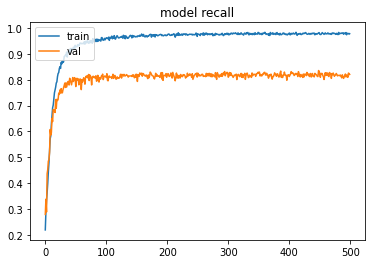

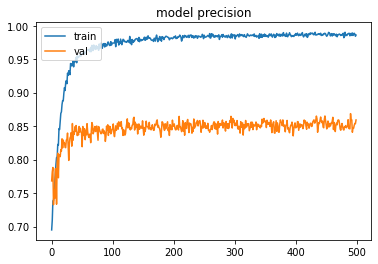

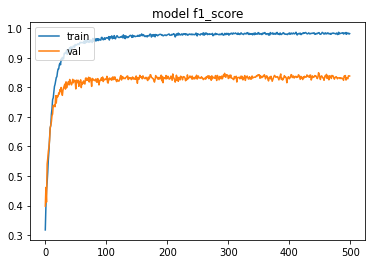

In [16]:


plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 10000)             0         
                                                                 
 gaussian_noise_4 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_23 (Dense)            (None, 1024)              10241024  
                                                                 
 dense_24 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                      

346/346 [==============================] - 7s 21ms/step - loss: 0.6335 - accuracy: 0.9760 - precision: 0.9232 - recall: 0.8813 - auc: 0.9917 - f1_score: 0.9012 - val_loss: 1.1762 - val_accuracy: 0.9504 - val_precision: 0.8156 - val_recall: 0.7792 - val_auc: 0.9564 - val_f1_score: 0.7967
Epoch 48/500
346/346 [==============================] - 8s 22ms/step - loss: 0.6244 - accuracy: 0.9770 - precision: 0.9267 - recall: 0.8860 - auc: 0.9919 - f1_score: 0.9051 - val_loss: 1.2767 - val_accuracy: 0.9526 - val_precision: 0.8241 - val_recall: 0.7897 - val_auc: 0.9484 - val_f1_score: 0.8057
Epoch 49/500
346/346 [==============================] - 8s 22ms/step - loss: 0.6212 - accuracy: 0.9762 - precision: 0.9220 - recall: 0.8844 - auc: 0.9922 - f1_score: 0.9023 - val_loss: 1.3026 - val_accuracy: 0.9472 - val_precision: 0.7958 - val_recall: 0.7767 - val_auc: 0.9491 - val_f1_score: 0.7860
Epoch 50/500
346/346 [==============================] - 7s 21ms/step - loss: 0.6323 - accuracy: 0.9771 - preci

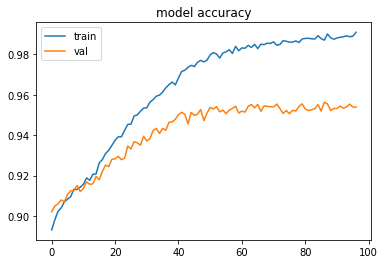

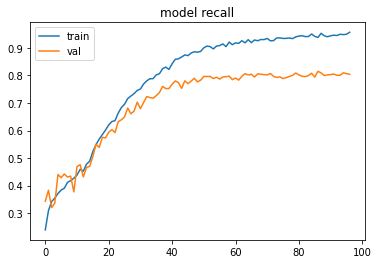

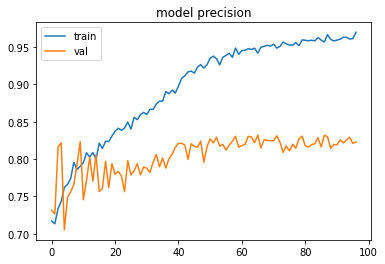

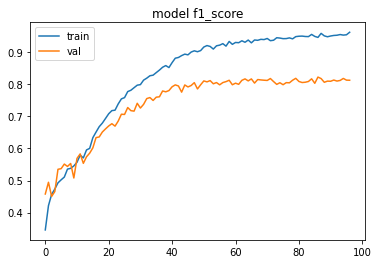

In [48]:

# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(X_train_kbest, y_train, validation_data=(X_test_kbest, y_test), epochs = 500,batch_size=16, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10), tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)



plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 10000)             0         
                                                                 
 gaussian_noise_2 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_14 (Dense)            (None, 1024)              10241024  
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               65664     
                                                      

Epoch 21/500
346/346 [==============================] - 6s 16ms/step - loss: 1.5421 - accuracy: 0.9084 - precision: 0.8220 - recall: 0.3412 - auc: 0.8631 - f1_score: 0.4690 - val_loss: 1.5269 - val_accuracy: 0.9114 - val_precision: 0.7896 - val_recall: 0.3970 - val_auc: 0.8676 - val_f1_score: 0.5191
Epoch 22/500
346/346 [==============================] - 6s 16ms/step - loss: 1.5382 - accuracy: 0.9094 - precision: 0.8241 - recall: 0.3495 - auc: 0.8642 - f1_score: 0.4807 - val_loss: 1.5737 - val_accuracy: 0.9102 - val_precision: 0.7816 - val_recall: 0.3906 - val_auc: 0.8570 - val_f1_score: 0.5124
Epoch 23/500
346/346 [==============================] - 5s 16ms/step - loss: 1.5143 - accuracy: 0.9100 - precision: 0.8268 - recall: 0.3544 - auc: 0.8683 - f1_score: 0.4842 - val_loss: 1.5451 - val_accuracy: 0.9113 - val_precision: 0.7880 - val_recall: 0.3978 - val_auc: 0.8690 - val_f1_score: 0.5204
Epoch 24/500
346/346 [==============================] - 6s 16ms/step - loss: 1.5054 - accuracy: 0

346/346 [==============================] - 7s 19ms/step - loss: 1.2386 - accuracy: 0.9184 - precision: 0.8379 - recall: 0.4305 - auc: 0.9305 - f1_score: 0.5607 - val_loss: 1.5523 - val_accuracy: 0.9008 - val_precision: 0.6481 - val_recall: 0.4517 - val_auc: 0.8944 - val_f1_score: 0.5277
Epoch 76/500
346/346 [==============================] - 7s 20ms/step - loss: 1.2365 - accuracy: 0.9198 - precision: 0.8314 - recall: 0.4491 - auc: 0.9312 - f1_score: 0.5758 - val_loss: 1.4705 - val_accuracy: 0.9159 - val_precision: 0.8828 - val_recall: 0.3776 - val_auc: 0.9017 - val_f1_score: 0.5182
Epoch 77/500
346/346 [==============================] - 7s 21ms/step - loss: 1.2434 - accuracy: 0.9195 - precision: 0.8303 - recall: 0.4471 - auc: 0.9300 - f1_score: 0.5729 - val_loss: 1.6639 - val_accuracy: 0.9126 - val_precision: 0.7882 - val_recall: 0.4109 - val_auc: 0.8964 - val_f1_score: 0.5315
Epoch 78/500
346/346 [==============================] - 7s 20ms/step - loss: 1.2720 - accuracy: 0.9202 - preci

346/346 [==============================] - 6s 19ms/step - loss: 1.1605 - accuracy: 0.9239 - precision: 0.8256 - recall: 0.4958 - auc: 0.9430 - f1_score: 0.6119 - val_loss: 1.5128 - val_accuracy: 0.9148 - val_precision: 0.7226 - val_recall: 0.5171 - val_auc: 0.9042 - val_f1_score: 0.5992
Epoch 130/500
346/346 [==============================] - 6s 19ms/step - loss: 1.1719 - accuracy: 0.9231 - precision: 0.8304 - recall: 0.4839 - auc: 0.9398 - f1_score: 0.6023 - val_loss: 1.5792 - val_accuracy: 0.9149 - val_precision: 0.8458 - val_recall: 0.3906 - val_auc: 0.8915 - val_f1_score: 0.5241
Epoch 131/500
346/346 [==============================] - 6s 19ms/step - loss: 1.1570 - accuracy: 0.9229 - precision: 0.8310 - recall: 0.4814 - auc: 0.9427 - f1_score: 0.6022 - val_loss: 1.5896 - val_accuracy: 0.9098 - val_precision: 0.6742 - val_recall: 0.5390 - val_auc: 0.9016 - val_f1_score: 0.5957
Epoch 132/500
346/346 [==============================] - 6s 19ms/step - loss: 1.1644 - accuracy: 0.9237 - pr

346/346 [==============================] - 6s 19ms/step - loss: 1.1363 - accuracy: 0.9256 - precision: 0.8374 - recall: 0.5023 - auc: 0.9458 - f1_score: 0.6218 - val_loss: 1.4885 - val_accuracy: 0.9068 - val_precision: 0.7711 - val_recall: 0.3620 - val_auc: 0.8908 - val_f1_score: 0.4857
Epoch 184/500
346/346 [==============================] - 6s 19ms/step - loss: 1.1335 - accuracy: 0.9251 - precision: 0.8195 - recall: 0.5141 - auc: 0.9461 - f1_score: 0.6248 - val_loss: 1.6192 - val_accuracy: 0.8992 - val_precision: 0.6302 - val_recall: 0.4690 - val_auc: 0.8924 - val_f1_score: 0.5342
Epoch 185/500
346/346 [==============================] - 6s 19ms/step - loss: 1.1402 - accuracy: 0.9258 - precision: 0.8291 - recall: 0.5117 - auc: 0.9450 - f1_score: 0.6263 - val_loss: 1.5652 - val_accuracy: 0.9100 - val_precision: 0.7536 - val_recall: 0.4164 - val_auc: 0.8985 - val_f1_score: 0.5304
Epoch 186/500
346/346 [==============================] - 6s 19ms/step - loss: 1.1170 - accuracy: 0.9255 - pr

346/346 [==============================] - 7s 19ms/step - loss: 1.1007 - accuracy: 0.9305 - precision: 0.8361 - recall: 0.5518 - auc: 0.9539 - f1_score: 0.6589 - val_loss: 1.5303 - val_accuracy: 0.9208 - val_precision: 0.8383 - val_recall: 0.4543 - val_auc: 0.9075 - val_f1_score: 0.5806
Epoch 238/500
346/346 [==============================] - 7s 19ms/step - loss: 1.0774 - accuracy: 0.9299 - precision: 0.8240 - recall: 0.5589 - auc: 0.9573 - f1_score: 0.6608 - val_loss: 2.7090 - val_accuracy: 0.9125 - val_precision: 0.7595 - val_recall: 0.4391 - val_auc: 0.8959 - val_f1_score: 0.5496
Epoch 239/500
346/346 [==============================] - 6s 19ms/step - loss: 1.1226 - accuracy: 0.9307 - precision: 0.8418 - recall: 0.5488 - auc: 0.9555 - f1_score: 0.6579 - val_loss: 1.5969 - val_accuracy: 0.9203 - val_precision: 0.7732 - val_recall: 0.5129 - val_auc: 0.9145 - val_f1_score: 0.6113
Epoch 240/500
346/346 [==============================] - 7s 19ms/step - loss: 1.0556 - accuracy: 0.9290 - pr

346/346 [==============================] - 7s 19ms/step - loss: 0.9738 - accuracy: 0.9349 - precision: 0.8330 - recall: 0.5999 - auc: 0.9650 - f1_score: 0.6929 - val_loss: 1.5363 - val_accuracy: 0.9135 - val_precision: 0.6877 - val_recall: 0.5643 - val_auc: 0.9157 - val_f1_score: 0.6159
Epoch 292/500
346/346 [==============================] - 7s 19ms/step - loss: 0.9828 - accuracy: 0.9363 - precision: 0.8502 - recall: 0.5957 - auc: 0.9649 - f1_score: 0.6950 - val_loss: 1.9310 - val_accuracy: 0.9227 - val_precision: 0.7871 - val_recall: 0.5234 - val_auc: 0.9013 - val_f1_score: 0.6231
Epoch 293/500
346/346 [==============================] - 7s 19ms/step - loss: 1.0732 - accuracy: 0.9335 - precision: 0.8367 - recall: 0.5811 - auc: 0.9592 - f1_score: 0.6798 - val_loss: 1.3916 - val_accuracy: 0.9182 - val_precision: 0.6934 - val_recall: 0.6203 - val_auc: 0.9219 - val_f1_score: 0.6529
Epoch 294/500
346/346 [==============================] - 7s 19ms/step - loss: 1.0198 - accuracy: 0.9361 - pr

346/346 [==============================] - 5s 16ms/step - loss: 0.9826 - accuracy: 0.9412 - precision: 0.8919 - recall: 0.6022 - auc: 0.9649 - f1_score: 0.7138 - val_loss: 1.5427 - val_accuracy: 0.9256 - val_precision: 0.7925 - val_recall: 0.5487 - val_auc: 0.9197 - val_f1_score: 0.6447
Epoch 346/500
346/346 [==============================] - 6s 16ms/step - loss: 0.9213 - accuracy: 0.9428 - precision: 0.8990 - recall: 0.6113 - auc: 0.9697 - f1_score: 0.7216 - val_loss: 1.3625 - val_accuracy: 0.9256 - val_precision: 0.7923 - val_recall: 0.5483 - val_auc: 0.9224 - val_f1_score: 0.6448
Epoch 347/500
346/346 [==============================] - 5s 16ms/step - loss: 0.9560 - accuracy: 0.9426 - precision: 0.8954 - recall: 0.6124 - auc: 0.9683 - f1_score: 0.7222 - val_loss: 1.9508 - val_accuracy: 0.9298 - val_precision: 0.8103 - val_recall: 0.5723 - val_auc: 0.9177 - val_f1_score: 0.6672
Epoch 348/500
346/346 [==============================] - 5s 16ms/step - loss: 0.9514 - accuracy: 0.9433 - pr

346/346 [==============================] - 5s 16ms/step - loss: 0.9206 - accuracy: 0.9468 - precision: 0.9083 - recall: 0.6389 - auc: 0.9729 - f1_score: 0.7445 - val_loss: 1.8248 - val_accuracy: 0.9184 - val_precision: 0.7402 - val_recall: 0.5343 - val_auc: 0.9011 - val_f1_score: 0.6171
Epoch 400/500
346/346 [==============================] - 6s 17ms/step - loss: 0.9014 - accuracy: 0.9464 - precision: 0.9083 - recall: 0.6355 - auc: 0.9729 - f1_score: 0.7430 - val_loss: 1.7281 - val_accuracy: 0.9217 - val_precision: 0.7427 - val_recall: 0.5719 - val_auc: 0.9114 - val_f1_score: 0.6425
Epoch 401/500
346/346 [==============================] - 6s 16ms/step - loss: 0.8899 - accuracy: 0.9466 - precision: 0.9048 - recall: 0.6404 - auc: 0.9732 - f1_score: 0.7447 - val_loss: 1.9061 - val_accuracy: 0.9282 - val_precision: 0.7978 - val_recall: 0.5702 - val_auc: 0.9181 - val_f1_score: 0.6621
Epoch 402/500
346/346 [==============================] - 6s 17ms/step - loss: 0.9577 - accuracy: 0.9463 - pr

346/346 [==============================] - 7s 19ms/step - loss: 0.9609 - accuracy: 0.9453 - precision: 0.9157 - recall: 0.6198 - auc: 0.9716 - f1_score: 0.7345 - val_loss: 1.5337 - val_accuracy: 0.9288 - val_precision: 0.8229 - val_recall: 0.5483 - val_auc: 0.9164 - val_f1_score: 0.6543
Epoch 453/500
346/346 [==============================] - 6s 17ms/step - loss: 0.8844 - accuracy: 0.9476 - precision: 0.9150 - recall: 0.6400 - auc: 0.9759 - f1_score: 0.7474 - val_loss: 1.8072 - val_accuracy: 0.9255 - val_precision: 0.7979 - val_recall: 0.5407 - val_auc: 0.9078 - val_f1_score: 0.6413
Epoch 454/500
346/346 [==============================] - 6s 17ms/step - loss: 0.9221 - accuracy: 0.9460 - precision: 0.9037 - recall: 0.6360 - auc: 0.9736 - f1_score: 0.7408 - val_loss: 1.6490 - val_accuracy: 0.9255 - val_precision: 0.8100 - val_recall: 0.5280 - val_auc: 0.9070 - val_f1_score: 0.6329
Epoch 455/500
346/346 [==============================] - 6s 17ms/step - loss: 0.9543 - accuracy: 0.9463 - pr

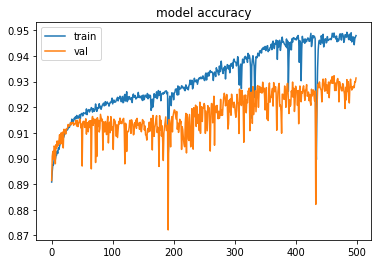

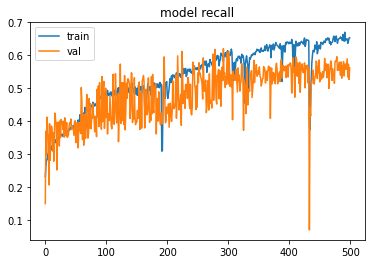

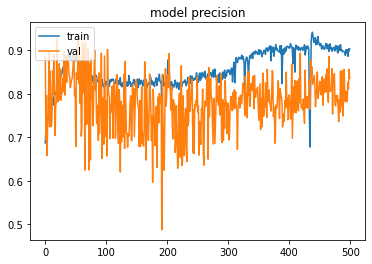

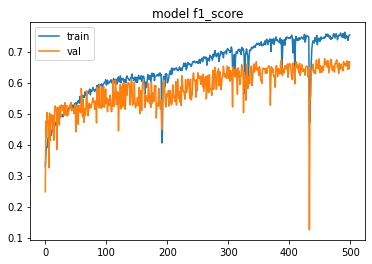

In [57]:

# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()



opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(X_train_kbest, y_train, validation_data=(X_test_kbest, y_test), epochs = 500,batch_size=16, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)



plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [185]:
tf.keras.backend.clear_session()



In [60]:
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))



opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(X_train_kbest, y_train, validation_data=(X_test_kbest, y_test), epochs = 500,batch_size=16, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)



Epoch 1/500
346/346 [==============================] - 10s 25ms/step - loss: 2.0874 - accuracy: 0.9103 - precision: 0.8610 - recall: 0.3369 - auc: 0.8561 - f1_score: 0.4715 - val_loss: 1.8240 - val_accuracy: 0.9159 - val_precision: 0.8362 - val_recall: 0.4067 - val_auc: 0.8667 - val_f1_score: 0.5373
Epoch 2/500
346/346 [==============================] - 10s 28ms/step - loss: 1.8002 - accuracy: 0.9076 - precision: 0.8286 - recall: 0.3291 - auc: 0.8589 - f1_score: 0.4621 - val_loss: 1.6895 - val_accuracy: 0.9012 - val_precision: 0.7856 - val_recall: 0.2887 - val_auc: 0.8776 - val_f1_score: 0.4147
Epoch 3/500
346/346 [==============================] - 7s 20ms/step - loss: 1.6702 - accuracy: 0.9071 - precision: 0.8143 - recall: 0.3327 - auc: 0.8684 - f1_score: 0.4624 - val_loss: 1.5873 - val_accuracy: 0.9085 - val_precision: 0.8878 - val_recall: 0.3068 - val_auc: 0.8854 - val_f1_score: 0.4468
Epoch 4/500
346/346 [==============================] - 7s 20ms/step - loss: 1.6348 - accuracy: 0.9

346/346 [==============================] - 7s 20ms/step - loss: 1.2597 - accuracy: 0.9149 - precision: 0.7885 - recall: 0.4364 - auc: 0.9186 - f1_score: 0.5546 - val_loss: 1.2817 - val_accuracy: 0.9176 - val_precision: 0.8478 - val_recall: 0.4155 - val_auc: 0.9138 - val_f1_score: 0.5473
Epoch 54/500
346/346 [==============================] - 7s 21ms/step - loss: 1.3409 - accuracy: 0.9110 - precision: 0.7440 - recall: 0.4393 - auc: 0.9067 - f1_score: 0.5461 - val_loss: 1.2972 - val_accuracy: 0.9176 - val_precision: 0.8048 - val_recall: 0.4501 - val_auc: 0.9104 - val_f1_score: 0.5692
Epoch 55/500
346/346 [==============================] - 7s 21ms/step - loss: 1.3019 - accuracy: 0.9107 - precision: 0.7499 - recall: 0.4290 - auc: 0.9121 - f1_score: 0.5375 - val_loss: 1.3070 - val_accuracy: 0.9197 - val_precision: 0.8297 - val_recall: 0.4496 - val_auc: 0.9056 - val_f1_score: 0.5766
Epoch 56/500
346/346 [==============================] - 7s 21ms/step - loss: 1.3179 - accuracy: 0.9114 - preci

346/346 [==============================] - 8s 22ms/step - loss: 1.2551 - accuracy: 0.9141 - precision: 0.7663 - recall: 0.4496 - auc: 0.9206 - f1_score: 0.5597 - val_loss: 1.2610 - val_accuracy: 0.9180 - val_precision: 0.8274 - val_recall: 0.4345 - val_auc: 0.9148 - val_f1_score: 0.5627
Epoch 108/500
346/346 [==============================] - 8s 23ms/step - loss: 1.2199 - accuracy: 0.9159 - precision: 0.7713 - recall: 0.4653 - auc: 0.9237 - f1_score: 0.5728 - val_loss: 1.2769 - val_accuracy: 0.9184 - val_precision: 0.8204 - val_recall: 0.4446 - val_auc: 0.9105 - val_f1_score: 0.5692
Epoch 109/500
346/346 [==============================] - 7s 21ms/step - loss: 1.2342 - accuracy: 0.9151 - precision: 0.7742 - recall: 0.4529 - auc: 0.9213 - f1_score: 0.5651 - val_loss: 1.3034 - val_accuracy: 0.9146 - val_precision: 0.8386 - val_recall: 0.3919 - val_auc: 0.9057 - val_f1_score: 0.5262
Epoch 110/500
346/346 [==============================] - 7s 21ms/step - loss: 1.2283 - accuracy: 0.9150 - pr

346/346 [==============================] - 9s 25ms/step - loss: 1.2294 - accuracy: 0.9158 - precision: 0.7807 - recall: 0.4541 - auc: 0.9225 - f1_score: 0.5658 - val_loss: 1.2538 - val_accuracy: 0.9165 - val_precision: 0.8391 - val_recall: 0.4109 - val_auc: 0.9162 - val_f1_score: 0.5435
Epoch 162/500
346/346 [==============================] - 7s 21ms/step - loss: 1.2253 - accuracy: 0.9115 - precision: 0.7613 - recall: 0.4252 - auc: 0.9235 - f1_score: 0.5387 - val_loss: 1.2709 - val_accuracy: 0.9165 - val_precision: 0.8332 - val_recall: 0.4147 - val_auc: 0.9141 - val_f1_score: 0.5439
Epoch 163/500
346/346 [==============================] - 7s 21ms/step - loss: 1.1992 - accuracy: 0.9139 - precision: 0.7555 - recall: 0.4604 - auc: 0.9272 - f1_score: 0.5650 - val_loss: 1.2563 - val_accuracy: 0.9129 - val_precision: 0.7555 - val_recall: 0.4480 - val_auc: 0.9150 - val_f1_score: 0.5561
Epoch 164/500
346/346 [==============================] - 7s 21ms/step - loss: 1.1908 - accuracy: 0.9162 - pr

346/346 [==============================] - 7s 20ms/step - loss: 1.2405 - accuracy: 0.9121 - precision: 0.7428 - recall: 0.4539 - auc: 0.9210 - f1_score: 0.5581 - val_loss: 1.2751 - val_accuracy: 0.9156 - val_precision: 0.8821 - val_recall: 0.3751 - val_auc: 0.9095 - val_f1_score: 0.5165
Epoch 216/500
346/346 [==============================] - 7s 20ms/step - loss: 1.1892 - accuracy: 0.9152 - precision: 0.7689 - recall: 0.4597 - auc: 0.9277 - f1_score: 0.5692 - val_loss: 1.2715 - val_accuracy: 0.9200 - val_precision: 0.8490 - val_recall: 0.4383 - val_auc: 0.9094 - val_f1_score: 0.5704
Epoch 217/500
346/346 [==============================] - 7s 20ms/step - loss: 1.2295 - accuracy: 0.9156 - precision: 0.7742 - recall: 0.4583 - auc: 0.9227 - f1_score: 0.5682 - val_loss: 1.2875 - val_accuracy: 0.9151 - val_precision: 0.9044 - val_recall: 0.3586 - val_auc: 0.9121 - val_f1_score: 0.5018
Epoch 218/500
346/346 [==============================] - 7s 20ms/step - loss: 1.1511 - accuracy: 0.9181 - pr

346/346 [==============================] - 7s 20ms/step - loss: 1.1601 - accuracy: 0.9183 - precision: 0.7741 - recall: 0.4890 - auc: 0.9312 - f1_score: 0.5931 - val_loss: 1.2180 - val_accuracy: 0.9211 - val_precision: 0.8548 - val_recall: 0.4442 - val_auc: 0.9213 - val_f1_score: 0.5766
Epoch 270/500
346/346 [==============================] - 7s 20ms/step - loss: 1.1550 - accuracy: 0.9176 - precision: 0.7756 - recall: 0.4794 - auc: 0.9318 - f1_score: 0.5860 - val_loss: 1.2310 - val_accuracy: 0.9180 - val_precision: 0.7397 - val_recall: 0.5306 - val_auc: 0.9192 - val_f1_score: 0.6135
Epoch 271/500
346/346 [==============================] - 7s 20ms/step - loss: 1.1771 - accuracy: 0.9169 - precision: 0.7726 - recall: 0.4745 - auc: 0.9290 - f1_score: 0.5806 - val_loss: 1.2384 - val_accuracy: 0.9195 - val_precision: 0.8416 - val_recall: 0.4387 - val_auc: 0.9176 - val_f1_score: 0.5680
Epoch 272/500
346/346 [==============================] - 7s 20ms/step - loss: 1.1693 - accuracy: 0.9162 - pr

346/346 [==============================] - 7s 21ms/step - loss: 1.1971 - accuracy: 0.9134 - precision: 0.7496 - recall: 0.4617 - auc: 0.9269 - f1_score: 0.5664 - val_loss: 1.3550 - val_accuracy: 0.9097 - val_precision: 0.6859 - val_recall: 0.5116 - val_auc: 0.8995 - val_f1_score: 0.5821
Epoch 324/500
346/346 [==============================] - 7s 21ms/step - loss: 1.2535 - accuracy: 0.9079 - precision: 0.7207 - recall: 0.4292 - auc: 0.9193 - f1_score: 0.5316 - val_loss: 1.2932 - val_accuracy: 0.9059 - val_precision: 0.6483 - val_recall: 0.5407 - val_auc: 0.9062 - val_f1_score: 0.5876
Epoch 325/500
346/346 [==============================] - 7s 21ms/step - loss: 1.3011 - accuracy: 0.9077 - precision: 0.7150 - recall: 0.4346 - auc: 0.9128 - f1_score: 0.5336 - val_loss: 1.4062 - val_accuracy: 0.9107 - val_precision: 0.7781 - val_recall: 0.3991 - val_auc: 0.8950 - val_f1_score: 0.5217
Epoch 326/500
346/346 [==============================] - 7s 21ms/step - loss: 1.2422 - accuracy: 0.9097 - pr

346/346 [==============================] - 7s 21ms/step - loss: 1.1784 - accuracy: 0.9180 - precision: 0.7754 - recall: 0.4846 - auc: 0.9296 - f1_score: 0.5898 - val_loss: 1.2874 - val_accuracy: 0.9178 - val_precision: 0.8063 - val_recall: 0.4509 - val_auc: 0.9079 - val_f1_score: 0.5719
Epoch 378/500
346/346 [==============================] - 7s 21ms/step - loss: 1.2225 - accuracy: 0.9131 - precision: 0.7513 - recall: 0.4552 - auc: 0.9263 - f1_score: 0.5614 - val_loss: 1.3395 - val_accuracy: 0.9153 - val_precision: 0.7296 - val_recall: 0.5129 - val_auc: 0.9088 - val_f1_score: 0.5990
Epoch 379/500
346/346 [==============================] - 7s 20ms/step - loss: 1.1961 - accuracy: 0.9163 - precision: 0.7654 - recall: 0.4767 - auc: 0.9286 - f1_score: 0.5827 - val_loss: 1.2642 - val_accuracy: 0.9176 - val_precision: 0.8228 - val_recall: 0.4345 - val_auc: 0.9120 - val_f1_score: 0.5624
Epoch 380/500
346/346 [==============================] - 7s 21ms/step - loss: 1.1898 - accuracy: 0.9159 - pr

346/346 [==============================] - 8s 23ms/step - loss: 1.2536 - accuracy: 0.9072 - precision: 0.7106 - recall: 0.4346 - auc: 0.9167 - f1_score: 0.5326 - val_loss: 1.3316 - val_accuracy: 0.9108 - val_precision: 0.7640 - val_recall: 0.4147 - val_auc: 0.9050 - val_f1_score: 0.5306
Epoch 432/500
346/346 [==============================] - 8s 23ms/step - loss: 1.2493 - accuracy: 0.9085 - precision: 0.7082 - recall: 0.4556 - auc: 0.9165 - f1_score: 0.5491 - val_loss: 1.3181 - val_accuracy: 0.9100 - val_precision: 0.6863 - val_recall: 0.5162 - val_auc: 0.9047 - val_f1_score: 0.5854
Epoch 433/500
346/346 [==============================] - 8s 23ms/step - loss: 1.2462 - accuracy: 0.9077 - precision: 0.7112 - recall: 0.4409 - auc: 0.9175 - f1_score: 0.5389 - val_loss: 1.3516 - val_accuracy: 0.9112 - val_precision: 0.7650 - val_recall: 0.4185 - val_auc: 0.9053 - val_f1_score: 0.5346
Epoch 434/500
346/346 [==============================] - 9s 25ms/step - loss: 1.2431 - accuracy: 0.9088 - pr

346/346 [==============================] - 7s 21ms/step - loss: 1.2641 - accuracy: 0.9077 - precision: 0.7001 - recall: 0.4579 - auc: 0.9162 - f1_score: 0.5483 - val_loss: 1.3125 - val_accuracy: 0.9086 - val_precision: 0.6774 - val_recall: 0.5133 - val_auc: 0.9061 - val_f1_score: 0.5789
Epoch 486/500
346/346 [==============================] - 7s 21ms/step - loss: 1.2390 - accuracy: 0.9083 - precision: 0.7089 - recall: 0.4523 - auc: 0.9185 - f1_score: 0.5462 - val_loss: 1.3048 - val_accuracy: 0.9117 - val_precision: 0.7740 - val_recall: 0.4142 - val_auc: 0.9053 - val_f1_score: 0.5329
Epoch 487/500
346/346 [==============================] - 8s 22ms/step - loss: 1.2619 - accuracy: 0.9072 - precision: 0.7039 - recall: 0.4444 - auc: 0.9153 - f1_score: 0.5387 - val_loss: 1.3327 - val_accuracy: 0.9108 - val_precision: 0.7632 - val_recall: 0.4155 - val_auc: 0.8988 - val_f1_score: 0.5304
Epoch 488/500
346/346 [==============================] - 7s 21ms/step - loss: 1.2423 - accuracy: 0.9078 - pr

In [54]:

opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]


def build_model(hp):
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(10000,),))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.GaussianNoise(0.3))
    model.add(tf.keras.layers.Dense(hp.Choice('units', [256, 512, 1024]), activation='relu'))#, kernel_regularizer='l1'))
    model.add(tf.keras.layers.Dense(hp.Choice('units2', [64, 128, 256, 512]), activation='relu'))#, kernel_regularizer='l1_l2')),
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(hp.Choice('units3', [64, 128, 256, 512]), activation='relu'))#, kernel_regularizer='l1_l2')),
    model.add(tf.keras.layers.Dense(hp.Choice('units4', [64, 128, 256, 512]), activation='relu'))#, kernel_regularizer='l1_l2')),
    model.add(tf.keras.layers.Dense(hp.Choice('units5', [64, 128, 256, 512]), activation='relu'))#, kernel_regularizer='l1_l2')),
    model.add(tf.keras.layers.Dense(hp.Choice('units6', [32,64, 128, 256]), activation='relu'))#, kernel_regularizer='l1_l2')),
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'
    return model

tuner = kt.RandomSearch( build_model, objective= kt.Objective("val_accuracy", direction="max"), max_trials=30,overwrite=True)
tuner.search(X_train_kbest, y_train, validation_data=(X_test_kbest, y_test), epochs=50)
best_model = tuner.get_best_models()[0]
# history = model.fit(np.stack(df.vecs.values), onehot, validation_split=0.2, epochs = 100, callbacks=[tf.keras.callbacks.ModelCheckpoint(
#         '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
#             save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)
best_hp.values

Trial 30 Complete [00h 02m 35s]
val_accuracy: 0.9417403936386108

Best val_accuracy So Far: 0.9475874304771423
Total elapsed time: 01h 19m 23s
INFO:tensorflow:Oracle triggered exit


NameError: name 'best_hp' is not defined

In [55]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'units': 1024,
 'units2': 512,
 'units3': 128,
 'units4': 128,
 'units5': 128,
 'units6': 128}

In [59]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 10000)             0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 10000)            0         
 se)                                                             
                                                                 
 dense (Dense)               (None, 1024)              10241024  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                        

In [23]:

model = XGBClassifier(n_estimators=100, max_depth=100, n_jobs=-1, eval_metric='auc', seed=42)#,verbosity =1)
model.fit(X_train_kbest, y_train)

# X_test_kbest, y_test
y_pred = model.predict(X_test_kbest)
# predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.60%


In [61]:
from sklearn import svm
clf = svm.SVC(kernel = "linear")
clf_trained = clf.fit(X_train_kbest, df.labels[:int(len(df)*i)])
clf_trained.score(X_test_kbest,df.labels[int(len(df)*i):])

0.7981458069953645

In [67]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gnb = GaussianNB()

# Train the classifier:
gnb.fit(X_train_kbest, df.labels[:int(len(df)*i)])
# X_test_kbest, y_test
y_pred = gnb.predict(X_test_kbest)
# predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(df.labels[int(len(df)*i):], y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 39.99%


In [69]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_kbest, df.labels[:int(len(df)*i)])
# X_test_kbest, y_test
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test_kbest,df.labels[int(len(df)*i):])))

C:\Users\mesla\PycharmProjects\breast_cancer_detection\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of Logistic regression classifier on test set: 0.78


In [71]:
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_kbest, df.labels[:int(len(df)*i)])
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_kbest,df.labels[int(len(df)*i):])))


Accuracy of K-NN classifier on test set: 0.66


In [72]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train_kbest, df.labels[:int(len(df)*i)])
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test_kbest,df.labels[int(len(df)*i):])))


Accuracy of Decision Tree classifier on test set: 0.63


C:\Users\mesla\AppData\Local\Temp\ipykernel_15888\1981224540.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classifiers, rotation = 45, ha="right")


<BarContainer object of 7 artists>

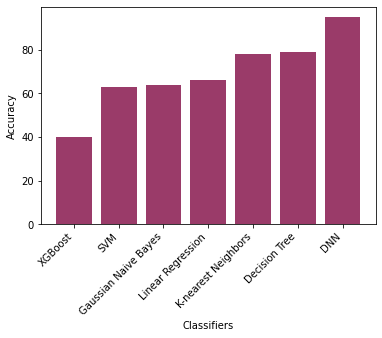

In [65]:
classifiers = ['XGBoost', 'SVM','Gaussian Naive Bayes','Linear Regression',
               'K-nearest Neighbors','Decision Tree','DNN']
val_acc = [64,79,40,78,66,63,95]

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_xticklabels(classifiers, rotation = 45, ha="right")
ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy')

plt.bar(np.array(pd.DataFrame(data={'classifier':classifiers, 'accuracy':val_acc}).sort_values(by=['accuracy'])[['classifier']]).reshape(-1)
       ,np.array(pd.DataFrame(data={'classifier':classifiers, 'accuracy':val_acc}).sort_values(by=['accuracy'])[['accuracy']]).reshape(-1)
       , color = '#9A3B69')


In [14]:
import os
import psutil  # need: 
print(psutil.virtual_memory())


svmem(total=17023582208, available=5697376256, percent=66.5, used=11326205952, free=5697376256)


In [13]:
import psutil
from psutil._common import bytes2human

mem_usage = psutil.virtual_memory()
total_in_human_format = bytes2human(mem_usage[0])
print(total_in_human_format)

15.9G


In [18]:
for row in psutil.virtual_memory():
    print(bytes2human(row))


15.9G
5.3G
66.6B
10.6G
5.3G
